In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import re
import numpy as np

In [ ]:
from google.colab import drive
drive.mount ("/content/drive")

Mounted at /content/drive


# Тепловые карты миграции

## Ямало-Ненецкий АО

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/migration.xlsx')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   territory_id             73 non-null     int64  
 1   region                   73 non-null     object 
 2   municipality_name        73 non-null     object 
 3   latitude                 73 non-null     float64
 4   longitude                73 non-null     float64
 5   value_of_migration_2023  73 non-null     int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 3.6+ KB


In [ ]:
gdf = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Ямало_Ненецкий_автономный_округ_Yamalo_Nenets_Autonomous_Region.txt')

In [ ]:
# Исправляем нормализацию для миграционных данных
def normalize_migration_name(name):
    name = name.lower().strip()

    # Убираем лишние части
    replacements = {
        'муниципальный округ': '',
        'городской округ город': '',
        'муниципальный район': '',
        'район': ''
    }

    for old, new in replacements.items():
        name = name.replace(old, new)

    # Убираем двойные пробелы
    name = ' '.join(name.split())

    # Добавляем "муниципальный район" в конец для районов (кроме городов и шурышкарского)
    if name not in ['лабытнанги', 'шурышкарский'] and any(word in name for word in ['красноселькупский', 'надымский', 'тазовский', 'ямальский', 'приуральский', 'пуровский']):
        name = name + ' муниципальный район'
    elif name == 'шурышкарский':
        name = 'шурышкарский муниципальный район'

    return name.strip()

# Применяем исправленную нормализацию
df['municipality_normalized'] = df['municipality_name'].apply(normalize_migration_name)

gdf['district_normalized'] = gdf['district'].str.lower()

# Проверим результаты
print("Исправленные нормализованные названия в миграции:")
yamal_df = df[df['region'] == 'ямало-ненецкий автономный округ']
print(yamal_df[['municipality_name', 'municipality_normalized']].to_string(index=False))

# Объединяем
merged = gdf.merge(
    df[df['region'] == 'ямало-ненецкий автономный округ'],
    left_on='district_normalized',
    right_on='municipality_normalized',
    how='left'
)

print("Результат объединения:")
result_check = merged[['district_normalized', 'municipality_normalized', 'value_of_migration_2023']].dropna(subset=['municipality_normalized'])
print(result_check.to_string(index=False))

print(f"\nУспешно объединено: {len(result_check)} из {len(yamal_df)} муниципалитетов")

Исправленные нормализованные названия в миграции:
                          municipality_name               municipality_normalized
           городской округ город лабытнанги                            лабытнанги
           шурышкарский муниципальный район      шурышкарский муниципальный район
     муниципальный округ приуральский район      приуральский муниципальный район
        муниципальный округ ямальский район         ямальский муниципальный район
муниципальный округ красноселькупский район красноселькупский муниципальный район
        муниципальный округ тазовский район         тазовский муниципальный район
        муниципальный округ пуровский район         пуровский муниципальный район
        муниципальный округ надымский район         надымский муниципальный район
Результат объединения:
                  district_normalized               municipality_normalized  value_of_migration_2023
красноселькупский муниципальный район красноселькупский муниципальный район             

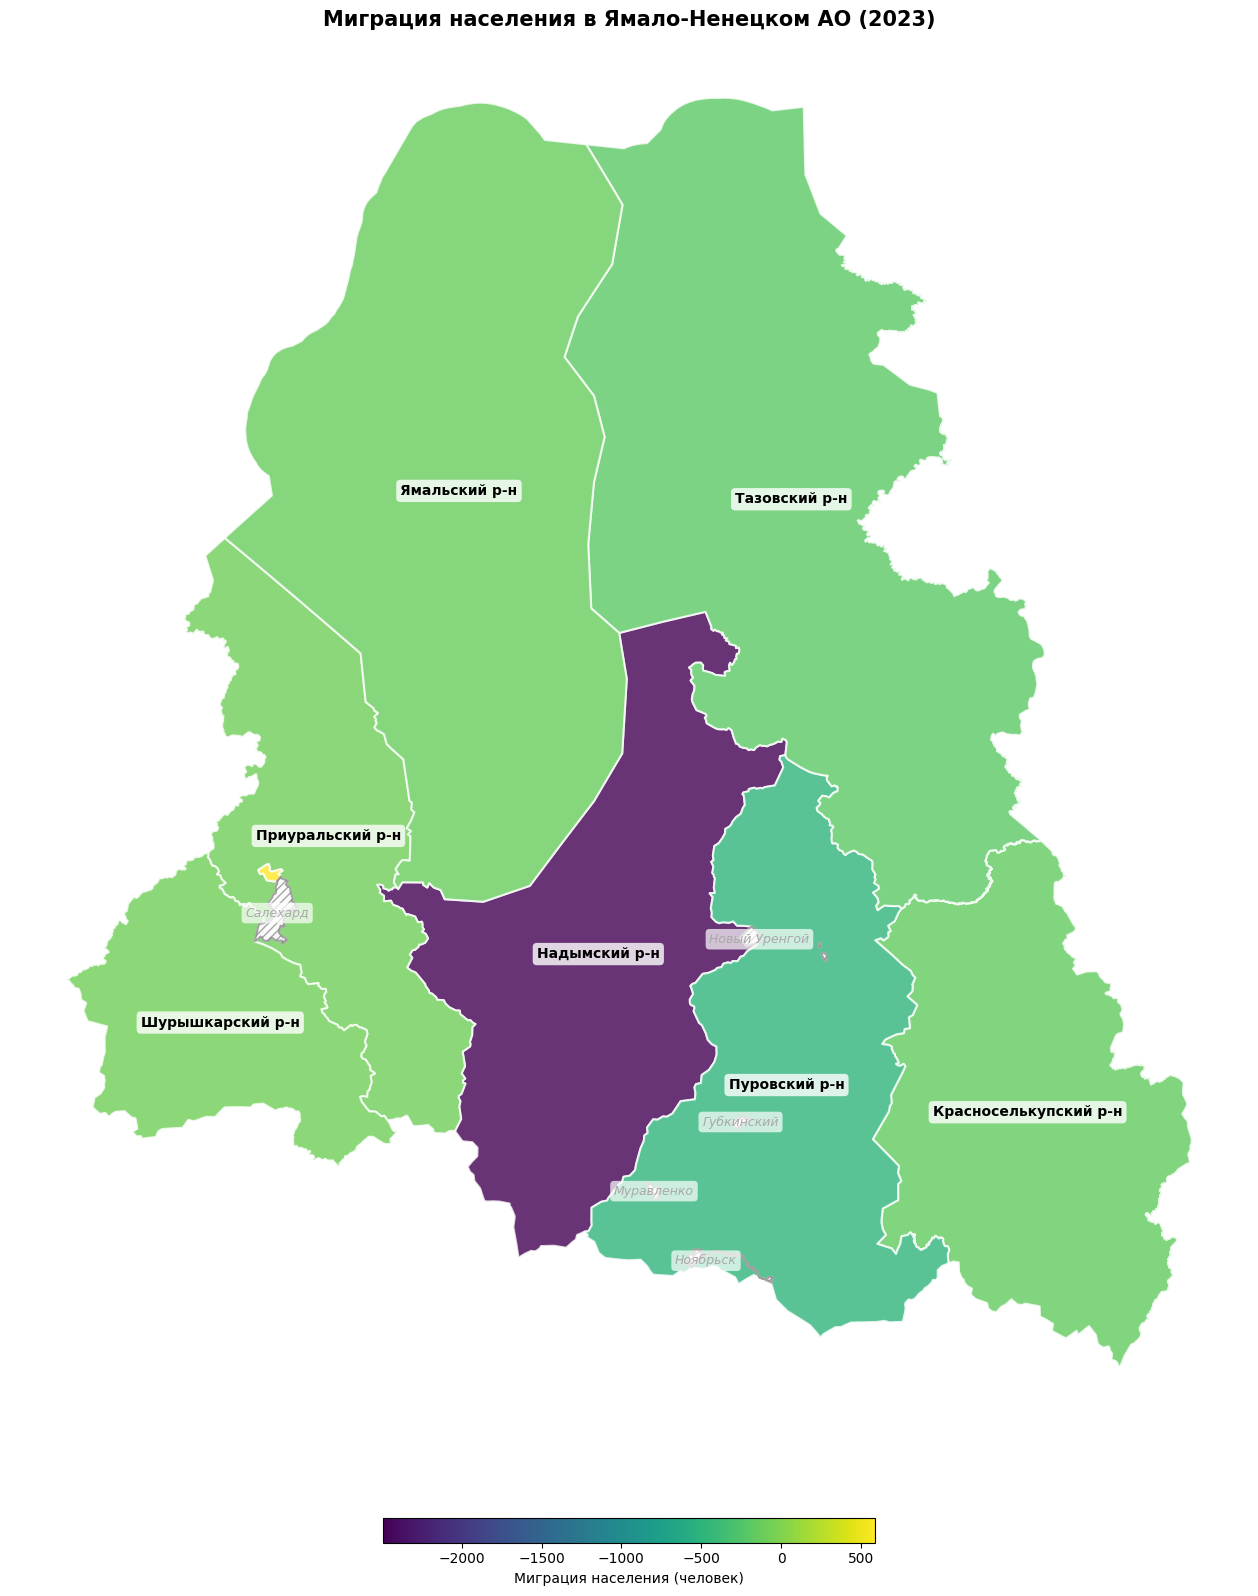

In [ ]:
# Создаем карту
fig, ax = plt.subplots(1, 1, figsize=(20, 18))

# Строим карту миграции
merged.plot(
    column='value_of_migration_2023',
    cmap='viridis',
    legend=True,
    ax=ax,
    edgecolor='white',
    linewidth=1.5,
    alpha=0.8,
    missing_kwds={
        'color': 'whitesmoke',
        'edgecolor': 'none',
        'alpha': 0.3
    },
    legend_kwds={
        'label': 'Миграция населения (человек)',
        'shrink': 0.25,
        'orientation': 'horizontal',
        'pad': 0.05
    }
)

# Штриховка для объектов без данных миграции
no_data_mask = merged['value_of_migration_2023'].isna()
if no_data_mask.any():
    merged[no_data_mask].plot(
        ax=ax,
        color='none',  # Прозрачная заливка
        edgecolor='grey',
        linewidth=1.5,
        hatch='////',  # Штриховка
        alpha=0.7
    )

ax.set_title('Миграция населения в Ямало-Ненецком АО (2023)',
             fontsize=15, fontweight='bold', color='black')
ax.set_axis_off()

# Добавляем подписи муниципалитетов
for idx, row in merged.iterrows():
    centroid = row['geometry'].centroid

    # Сокращаем названия
    district_name = row['district']
    if 'муниципальный район' in district_name:
        short_name = district_name.replace(' муниципальный район', ' р-н')
    elif 'район' in district_name:
        short_name = district_name.replace(' район', ' р-н')
    else:
        short_name = district_name

    # Пропускаем подпись для Лабытнанги
    if short_name == 'Лабытнанги':
        continue

    # Настройки подписей в зависимости от наличия данных
    if pd.notna(row['value_of_migration_2023']):
        ax.annotate(
            text=short_name,
            xy=(centroid.x, centroid.y),
            ha='center',
            va='center',
            fontsize=10,
            fontweight='bold',
            color='black',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.8,
                edgecolor='none'
            )
        )
    else:
        ax.annotate(
            text=short_name,
            xy=(centroid.x, centroid.y),
            ha='center',
            va='center',
            fontsize=9,
            color='darkgray',
            style='italic',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.7,
                edgecolor='none'
            )
        )

plt.tight_layout()
plt.show()

## Ханты-Мансийский АО

In [ ]:
gdf_KMAR = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Ханты-Мансийский автономный округ_Khanty-Mansy Autonomous Region.geojson')

In [ ]:
# Получение уникальных названий муниципалитетов
unique_districts_KMAR = gdf_KMAR['district'].unique()
print('Уникальные муниципалитеты:')
for district in sorted(unique_districts_KMAR):
    print(f"- {district}")

# Или просто список
print(f"\nВсего уникальных муниципалитетов: {len(unique_districts_KMAR)}")

Уникальные муниципалитеты:
- Белоярский муниципальный район
- Березовский муниципальный район
- Когалым
- Кондинский муниципальный район
- Лангепас
- Мегион
- Нефтеюганск
- Нефтеюганский муниципальный район
- Нижневартовск
- Нижневартовский муниципальный район
- Нягань
- Октябрьский муниципальный район
- Покачи
- Пыть-Ях
- Радужный
- Советский муниципальный район
- Сургут
- Сургутский муниципальный район
- Урай
- Ханты-Мансийск
- Ханты-Мансийский муниципальный район
- Югорск

Всего уникальных муниципалитетов: 22


In [ ]:
# Словарь для приведения названий к единому формату (как в геоданных)
district_mapping_KMAR = {
    'городской округ мегион': 'Мегион',
    'березовский муниципальный район': 'Березовский муниципальный район',
    'кондинский муниципальный район': 'Кондинский муниципальный район',
    'нефтеюганский муниципальный район': 'Нефтеюганский муниципальный район',
    'нижневартовский муниципальный район': 'Нижневартовский муниципальный район',
    'октябрьский муниципальный район': 'Октябрьский муниципальный район',
    'советский муниципальный район': 'Советский муниципальный район',
    'сургутский муниципальный район': 'Сургутский муниципальный район',
    'ханты-мансийский муниципальный район': 'Ханты-Мансийский муниципальный район'
}

df['district_normalized'] = df['municipality_name'].str.lower().map(district_mapping_KMAR)

# Удаляем строки, для которых не нашлось соответствия
migration_df_clean_KMAR = df.dropna(subset=['district_normalized'])

In [ ]:
# Объединяем геоданные с данными миграции
merged_KMAR = gdf_KMAR.merge(
    migration_df_clean_KMAR,
    left_on='district',
    right_on='district_normalized',
    how='left'
)

# Проверяем результат
print("Результат объединения:")
print(f"Всего записей: {len(merged)}")
print(f"Записей с данными миграции: {merged['value_of_migration_2023'].notna().sum()}")

Результат объединения:
Всего записей: 13
Записей с данными миграции: 8


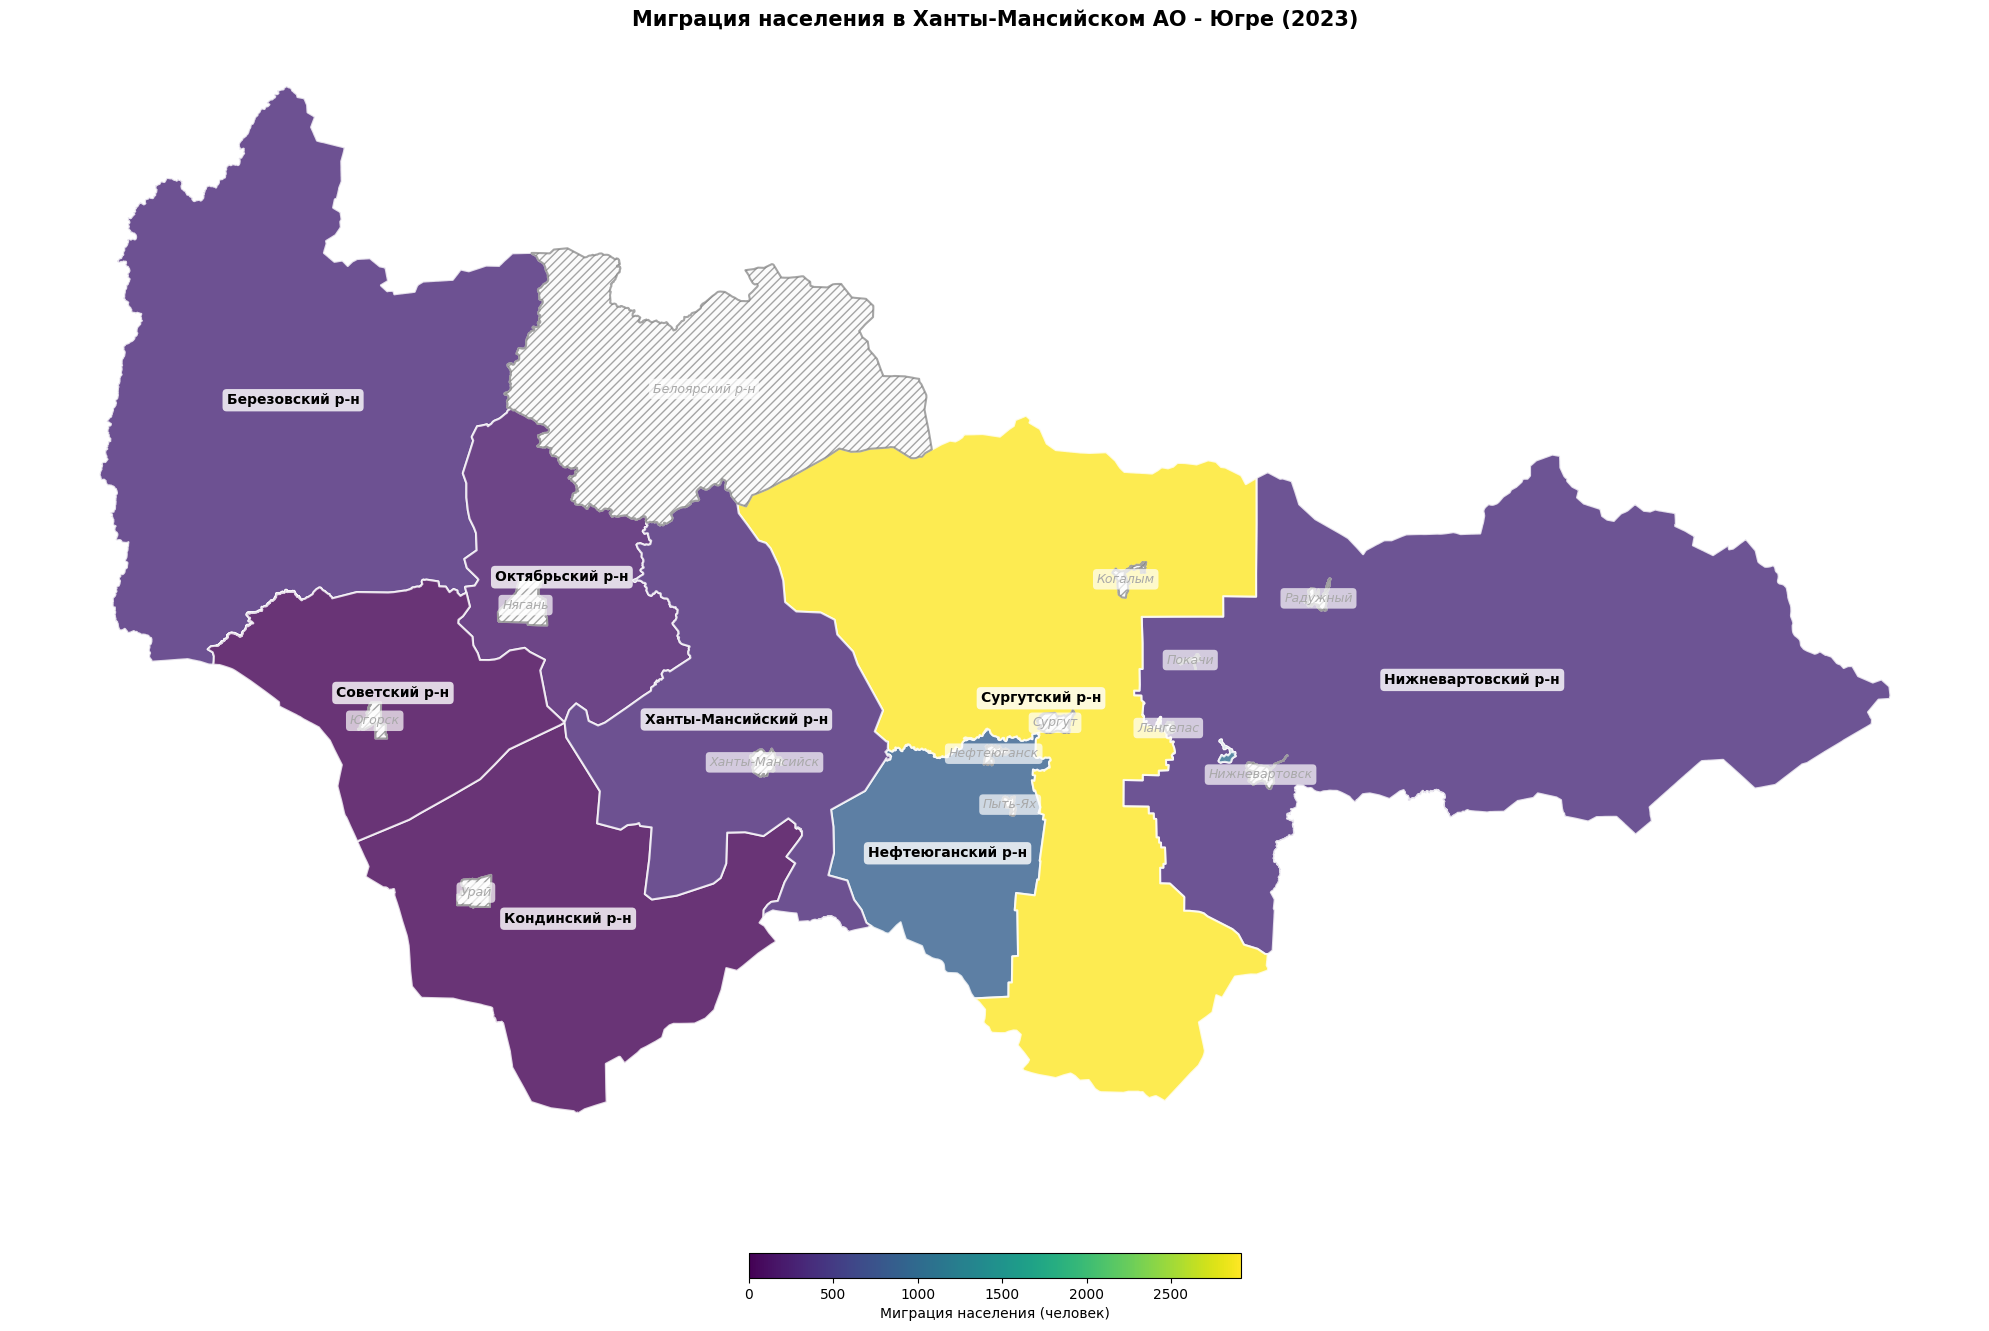

In [ ]:
fig_KMAR, ax_KMAR = plt.subplots(1, 1, figsize=(20, 18))

merged_KMAR.plot(
    column='value_of_migration_2023',
    cmap='viridis',
    legend=True,
    ax=ax_KMAR,
    edgecolor='white',
    linewidth=1.5,
    alpha=0.8,
    missing_kwds={
        'color': 'whitesmoke',
        'edgecolor': 'none',
        'alpha': 0.3
    },
    legend_kwds={
        'label': 'Миграция населения (человек)',
        'shrink': 0.25,
        'orientation': 'horizontal',
        'pad': 0.05
    }
)

# Штриховка для объектов без данных миграции
no_data_mask = merged_KMAR['value_of_migration_2023'].isna()
if no_data_mask.any():
    merged_KMAR[no_data_mask].plot(
        ax=ax_KMAR,
        color='none',  # Прозрачная заливка
        edgecolor='grey',
        linewidth=1.5,
        hatch='////',  # Штриховка
        alpha=0.7
    )

ax_KMAR.set_title('Миграция населения в Ханты-Мансийском АО - Югре (2023)',
                 fontsize=15, fontweight='bold', color='black')
ax_KMAR.set_axis_off()

# Добавляем подписи муниципалитетов для KMAR
for idx, row in merged_KMAR.iterrows():
    centroid_KMAR = row['geometry'].centroid

    # Сокращаем названия для KMAR
    district_name_KMAR = row['district']
    if 'муниципальный район' in district_name_KMAR:
        short_name_KMAR = district_name_KMAR.replace(' муниципальный район', ' р-н')
    elif 'район' in district_name_KMAR:
        short_name_KMAR = district_name_KMAR.replace(' район', ' р-н')
    else:
        short_name_KMAR = district_name_KMAR

    # Пропускаем подпись для Мегиона
    skip_districts_KMAR = ['Мегион']
    if short_name_KMAR in skip_districts_KMAR:
        continue

    if pd.notna(row['value_of_migration_2023']):
        ax_KMAR.annotate(
            text=short_name_KMAR,
            xy=(centroid_KMAR.x, centroid_KMAR.y),
            ha='center',
            va='center',
            fontsize=10,
            fontweight='bold',
            color='black',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.8,
                edgecolor='none'
            )
        )
    else:
        ax_KMAR.annotate(
            text=short_name_KMAR,
            xy=(centroid_KMAR.x, centroid_KMAR.y),
            ha='center',
            va='center',
            fontsize=9,
            color='darkgray',
            style='italic',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.7,
                edgecolor='none'
            )
        )

plt.tight_layout()
plt.show()

## Республика Карелия

In [ ]:
gdf_KR = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Республика Карелия_Karelia region.geojson')

In [ ]:
# Получение уникальных названий муниципалитетов
unique_districts_KR = gdf_KR['district'].unique()
print('Уникальные муниципалитеты:')
for district in sorted(unique_districts_KR):
    print(f"- {district}")

# Или просто список
print(f"\nВсего уникальных муниципалитетов: {len(unique_districts_KR)}")

Уникальные муниципалитеты:
- Беломорский район
- Калевальский район
- Кемский район
- Кондопожский район
- Костомукшский
- Лахденпохский район
- Лоухский район
- Медвежьегорский район
- Муезерский район
- Олонецкий район
- Петрозаводский
- Питкярантский район
- Прионежский район
- Пряжинский район
- Пудожский район
- Сегежский район
- Сортавальский район
- Суоярвский район

Всего уникальных муниципалитетов: 18


In [ ]:
# Словарь для приведения названий к единому формату
district_mapping_KR = {
    'калевальский муниципальный район': 'Калевальский район',
    'лоухский муниципальный район': 'Лоухский район',
    'медвежьегорский муниципальный район': 'Медвежьегорский район',
    'муезерский муниципальный район': 'Муезерский район',
    'сегежский муниципальный район': 'Сегежский район',
    'сортавальский муниципальный район': 'Сортавальский район'
}

df['district_normalized'] = df['municipality_name'].str.lower().map(district_mapping_KR)

# Удаляем строки, для которых не нашлось соответствия
migration_df_clean_KR = df.dropna(subset=['district_normalized'])

In [ ]:
# Объединяем геоданные с данными миграции
merged_KR = gdf_KR.merge(
    migration_df_clean_KR,
    left_on='district',
    right_on='district_normalized',
    how='left'
)

# Проверяем результат
print("Результат объединения:")
print(f"Всего записей: {len(merged_KR)}")
print(f"Записей с данными миграции: {merged_KR['value_of_migration_2023'].notna().sum()}")

Результат объединения:
Всего записей: 18
Записей с данными миграции: 6


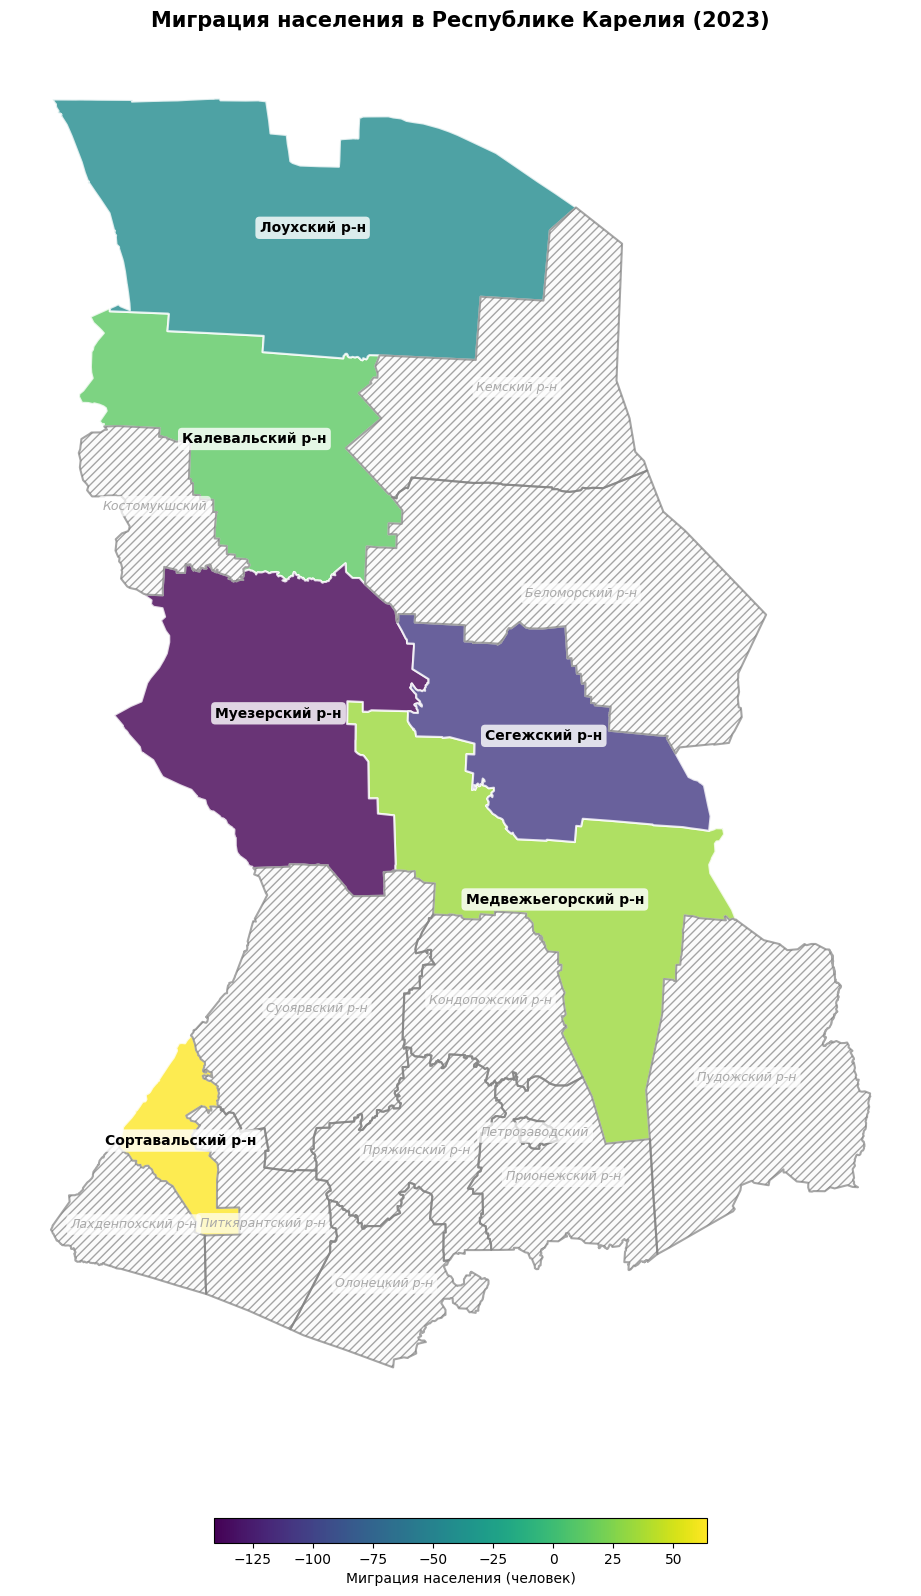

In [ ]:
fig_KR, ax_KR = plt.subplots(1, 1, figsize=(20, 18))

merged_KR.plot(
    column='value_of_migration_2023',
    cmap='viridis',
    legend=True,
    ax=ax_KR,
    edgecolor='white',
    linewidth=1.5,
    alpha=0.8,
    missing_kwds={
        'color': 'whitesmoke',
        'edgecolor': 'none',
        'alpha': 0.3
    },
    legend_kwds={
        'label': 'Миграция населения (человек)',
        'shrink': 0.25,
        'orientation': 'horizontal',
        'pad': 0.05
    }
)

# Штриховка для объектов без данных миграции
no_data_mask = merged_KR['value_of_migration_2023'].isna()
if no_data_mask.any():
    merged_KR[no_data_mask].plot(
        ax=ax_KR,
        color='none',  # Прозрачная заливка
        edgecolor='grey',
        linewidth=1.5,
        hatch='////',  # Штриховка
        alpha=0.7
    )

ax_KR.set_title('Миграция населения в Республике Карелия (2023)',
                 fontsize=15, fontweight='bold', color='black')
ax_KR.set_axis_off()

# Добавляем подписи муниципалитетов для NAD
for idx, row in merged_KR.iterrows():
    centroid_NAD = row['geometry'].centroid

    # Сокращаем названия для NAD
    district_name_KR = row['district']
    if 'район' in district_name_KR:
        short_name_KR = district_name_KR.replace(' район', ' р-н')
    else:
        short_name_KR = district_name_KR

    # Пропускаем подпись для определенных муниципалитетов (при необходимости)
    skip_districts_KR = []  # можно добавить муниципалитеты для пропуска, например ['Петрозаводск']
    if short_name_KR in skip_districts_KR:
        continue

    if pd.notna(row['value_of_migration_2023']):
        ax_KR.annotate(
            text=short_name_KR,
            xy=(centroid_NAD.x, centroid_NAD.y),
            ha='center',
            va='center',
            fontsize=10,
            fontweight='bold',
            color='black',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.8,
                edgecolor='none'
            )
        )
    else:
        ax_KR.annotate(
            text=short_name_KR,
            xy=(centroid_NAD.x, centroid_NAD.y),
            ha='center',
            va='center',
            fontsize=9,
            color='darkgray',
            style='italic',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.7,
                edgecolor='none'
            )
        )

plt.tight_layout()
plt.show()

## Ненецкий АО

In [ ]:
gdf_NAD = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Ненецкий автономный округ_Nenets Autonomous District.geojson')

In [ ]:
# Получение уникальных названий муниципалитетов
unique_districts_NAD = gdf_NAD['district'].unique()
print('Уникальные муниципалитеты:')
for district in sorted(unique_districts_NAD):
    print(f"- {district}")

# Или просто список
print(f"\nВсего уникальных муниципалитетов: {len(unique_districts_NAD)}")

Уникальные муниципалитеты:
- Муниципальный район Заполярный район
- Нарьян-Мар

Всего уникальных муниципалитетов: 2


In [ ]:
# Словарь для приведения названий к единому формату
district_mapping_NAD = {
    'заполярный муниципальный район': 'Муниципальный район Заполярный район',
}

df['district_normalized'] = df['municipality_name'].str.lower().map(district_mapping_NAD)

# Удаляем строки, для которых не нашлось соответствия
migration_df_clean_NAD = df.dropna(subset=['district_normalized'])

In [ ]:
# Объединяем геоданные с данными миграции
merged_NAD = gdf_NAD.merge(
    migration_df_clean_NAD,
    left_on='district',
    right_on='district_normalized',
    how='left'
)

# Проверяем результат
print("Результат объединения: ")
print(f"Всего записей: {len(merged_NAD)}")
print(f"Записей с данными миграции: {merged_NAD['value_of_migration_2023'].notna().sum()}")

Результат объединения: 
Всего записей: 2
Записей с данными миграции: 1


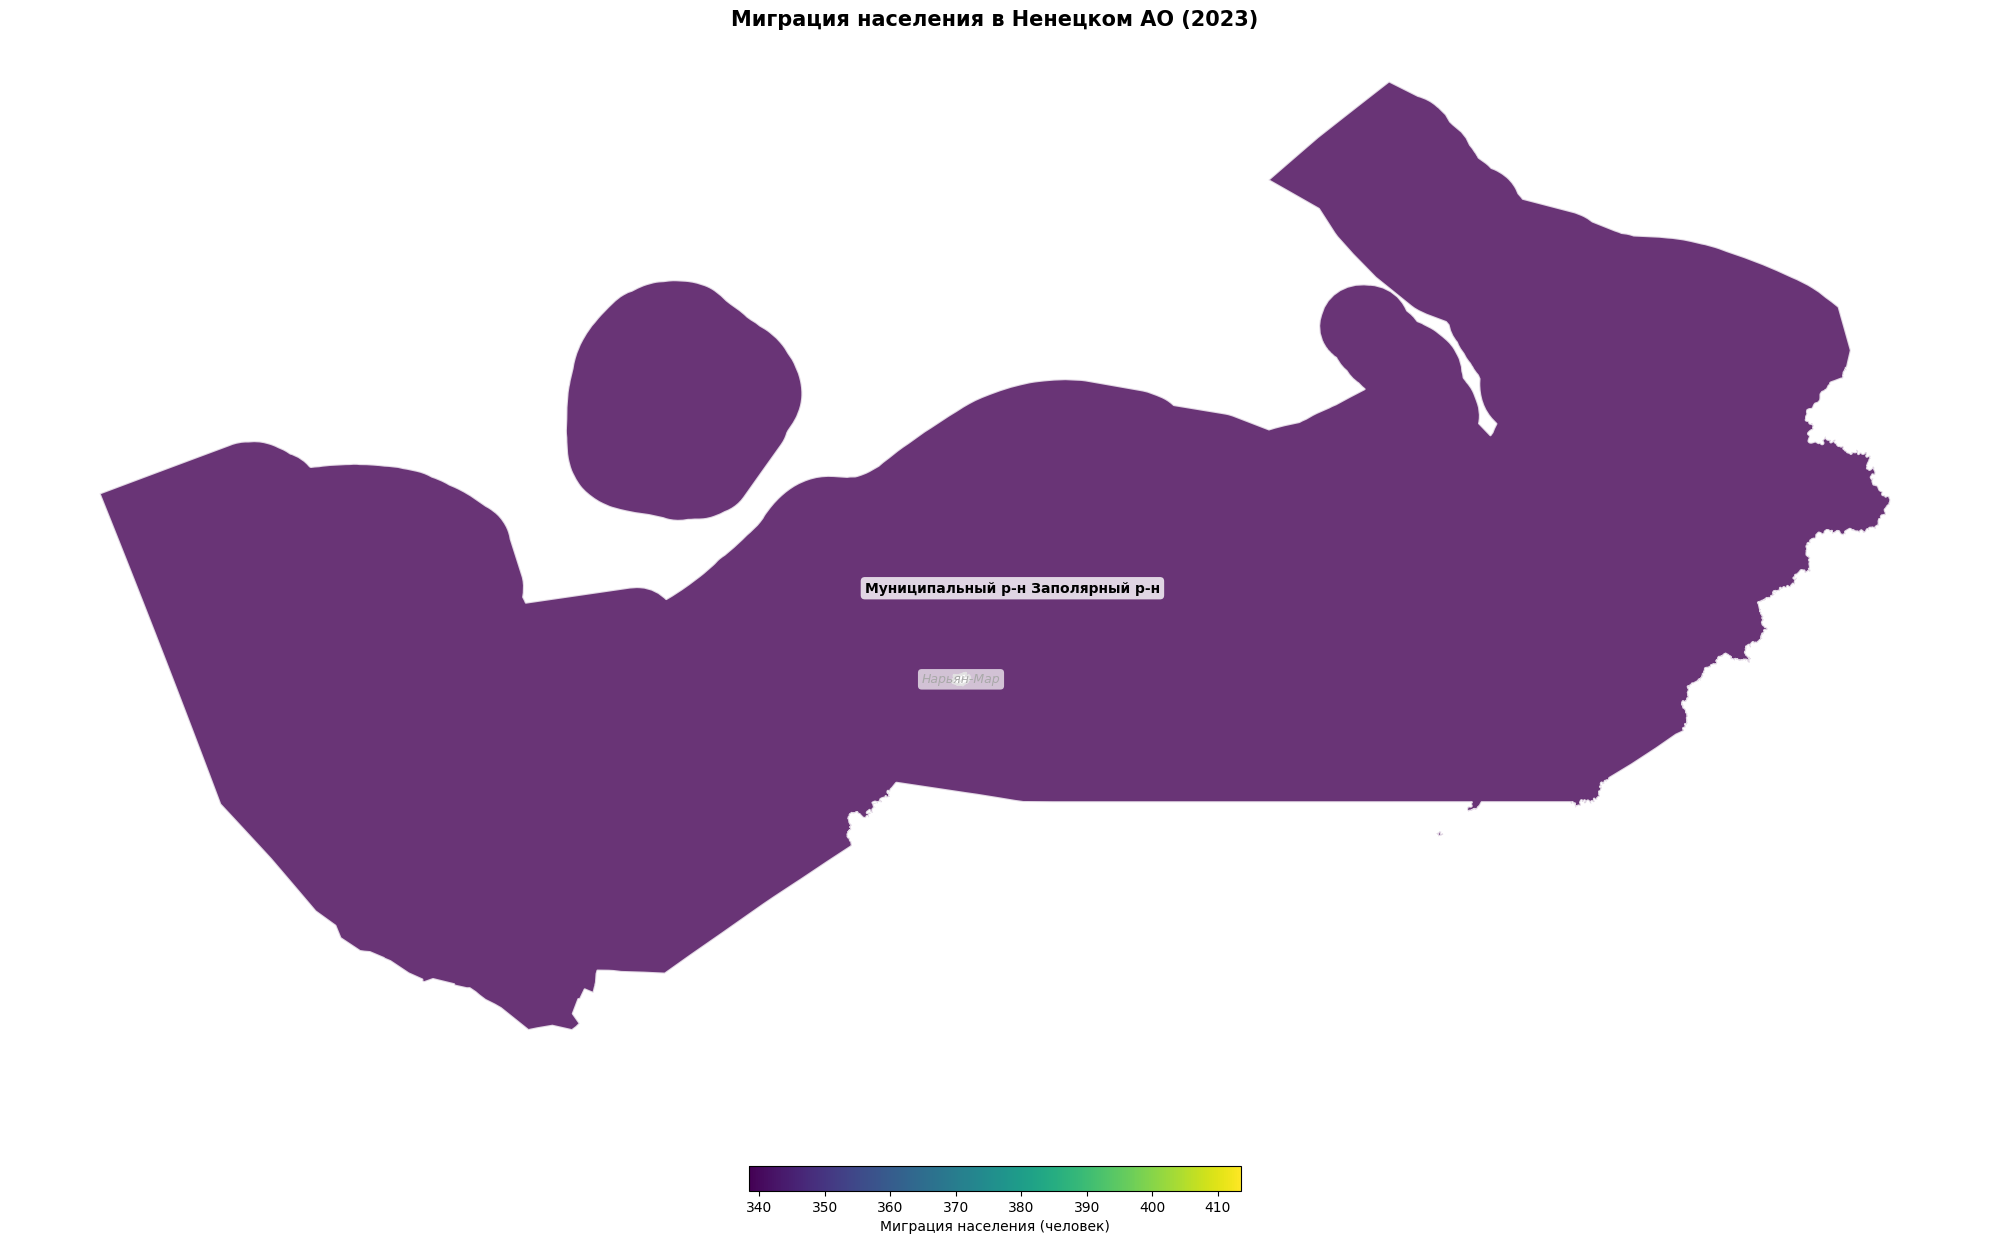

In [ ]:
fig_NAD, ax_NAD = plt.subplots(1, 1, figsize=(20, 18))

merged_NAD.plot(
    column='value_of_migration_2023',
    cmap='viridis',
    legend=True,
    ax=ax_NAD,
    edgecolor='white',
    linewidth=1.5,
    alpha=0.8,
    missing_kwds={
        'color': 'whitesmoke',
        'edgecolor': 'none',
        'alpha': 0.3
    },
    legend_kwds={
        'label': 'Миграция населения (человек)',
        'shrink': 0.25,
        'orientation': 'horizontal',
        'pad': 0.05
    }
)

# Штриховка для объектов без данных миграции
no_data_mask = merged_NAD['value_of_migration_2023'].isna()
if no_data_mask.any():
    merged_NAD[no_data_mask].plot(
        ax=ax_NAD,
        color='none',  # Прозрачная заливка
        edgecolor='grey',
        linewidth=1.5,
        hatch='////',  # Штриховка
        alpha=0.7
    )

ax_NAD.set_title('Миграция населения в Ненецком АО (2023)',
                 fontsize=15, fontweight='bold', color='black')
ax_NAD.set_axis_off()

# Добавляем подписи муниципалитетов для NAD
for idx, row in merged_NAD.iterrows():
    centroid_NAD = row['geometry'].centroid

    # Сокращаем названия для NAD
    district_name_NAD = row['district']
    if 'район' in district_name_NAD:
        short_name_NAD = district_name_NAD.replace(' район', ' р-н')
    else:
        short_name_NAD = district_name_NAD

    # Пропускаем подпись для определенных муниципалитетов (при необходимости)
    skip_districts_NAD = []  # можно добавить муниципалитеты для пропуска, например ['Петрозаводск']
    if short_name_NAD in skip_districts_NAD:
        continue

    if pd.notna(row['value_of_migration_2023']):
        ax_NAD.annotate(
            text=short_name_NAD,
            xy=(centroid_NAD.x, centroid_NAD.y),
            ha='center',
            va='center',
            fontsize=10,
            fontweight='bold',
            color='black',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.8,
                edgecolor='none'
            )
        )
    else:
        ax_NAD.annotate(
            text=short_name_NAD,
            xy=(centroid_NAD.x, centroid_NAD.y),
            ha='center',
            va='center',
            fontsize=9,
            color='darkgray',
            style='italic',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.7,
                edgecolor='none'
            )
        )

plt.tight_layout()
plt.show()

## Республика Саха (Якутия)

In [ ]:
gdf_YA = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Республика Саха (Якутия)_Yakutia.geojson')

In [ ]:
# Получение уникальных названий муниципалитетов
unique_districts_YA = gdf_YA['district'].unique()
print('Уникальные муниципалитеты:')
for district in sorted(unique_districts_YA):
    print(f"- {district}")

# Или просто список
print(f"\nВсего уникальных муниципалитетов: {len(unique_districts_YA)}")

Уникальные муниципалитеты:
- Абыйский район
- Алданский район
- Аллаиховский район
- Амгинский район
- Анабарский район
- Булунский район
- Верхневилюйский район
- Верхнеколымский район
- Верхоянский район
- Вилюйский район
- Горный район
- Жатай
- Жиганский район
- Кобяйский район
- Ленский район
- Мегино-Кангаласский район
- Мирнинский район
- Момский район
- Намский район
- Нерюнгринский район
- Нижнеколымский район
- Нюрбинский район
- Оймяконский район
- Оленёкский район
- Олёкминский район
- Среднеколымский район
- Сунтарский район
- Таттинский район
- Томпонский район
- Усть-Алданский район
- Усть-Майский район
- Усть-Янский район
- Хангаласский район
- Чурапчинский район
- Эвено-Бытантайский район
- город Якутск

Всего уникальных муниципалитетов: 36


In [ ]:
# Словарь для приведения названий муниципальных районов к единому формату
district_mapping_YA = {
    'верхнеколымский муниципальный район': 'Верхнеколымский район',
    'нюрбинский муниципальный район': 'Нюрбинский район',
    'мирнинский муниципальный район': 'Мирнинский район',
    'усть-майский муниципальный район': 'Усть-Майский район',
    'усть-янский муниципальный район': 'Усть-Янский район'
}

df['district_normalized'] = df['municipality_name'].str.lower().map(district_mapping_YA)

# Удаляем строки, для которых не нашлось соответствия
migration_df_clean_YA = df.dropna(subset=['district_normalized'])

In [ ]:
# Объединяем геоданные с данными миграции
merged_YA = gdf_YA.merge(
    migration_df_clean_YA,
    left_on='district',
    right_on='district_normalized',
    how='left'
)

# Проверяем результат
print("Результат объединения: ")
print(f"Всего записей: {len(merged_YA)}")
print(f"Записей с данными миграции: {merged_YA['value_of_migration_2023'].notna().sum()}")

Результат объединения: 
Всего записей: 36
Записей с данными миграции: 5


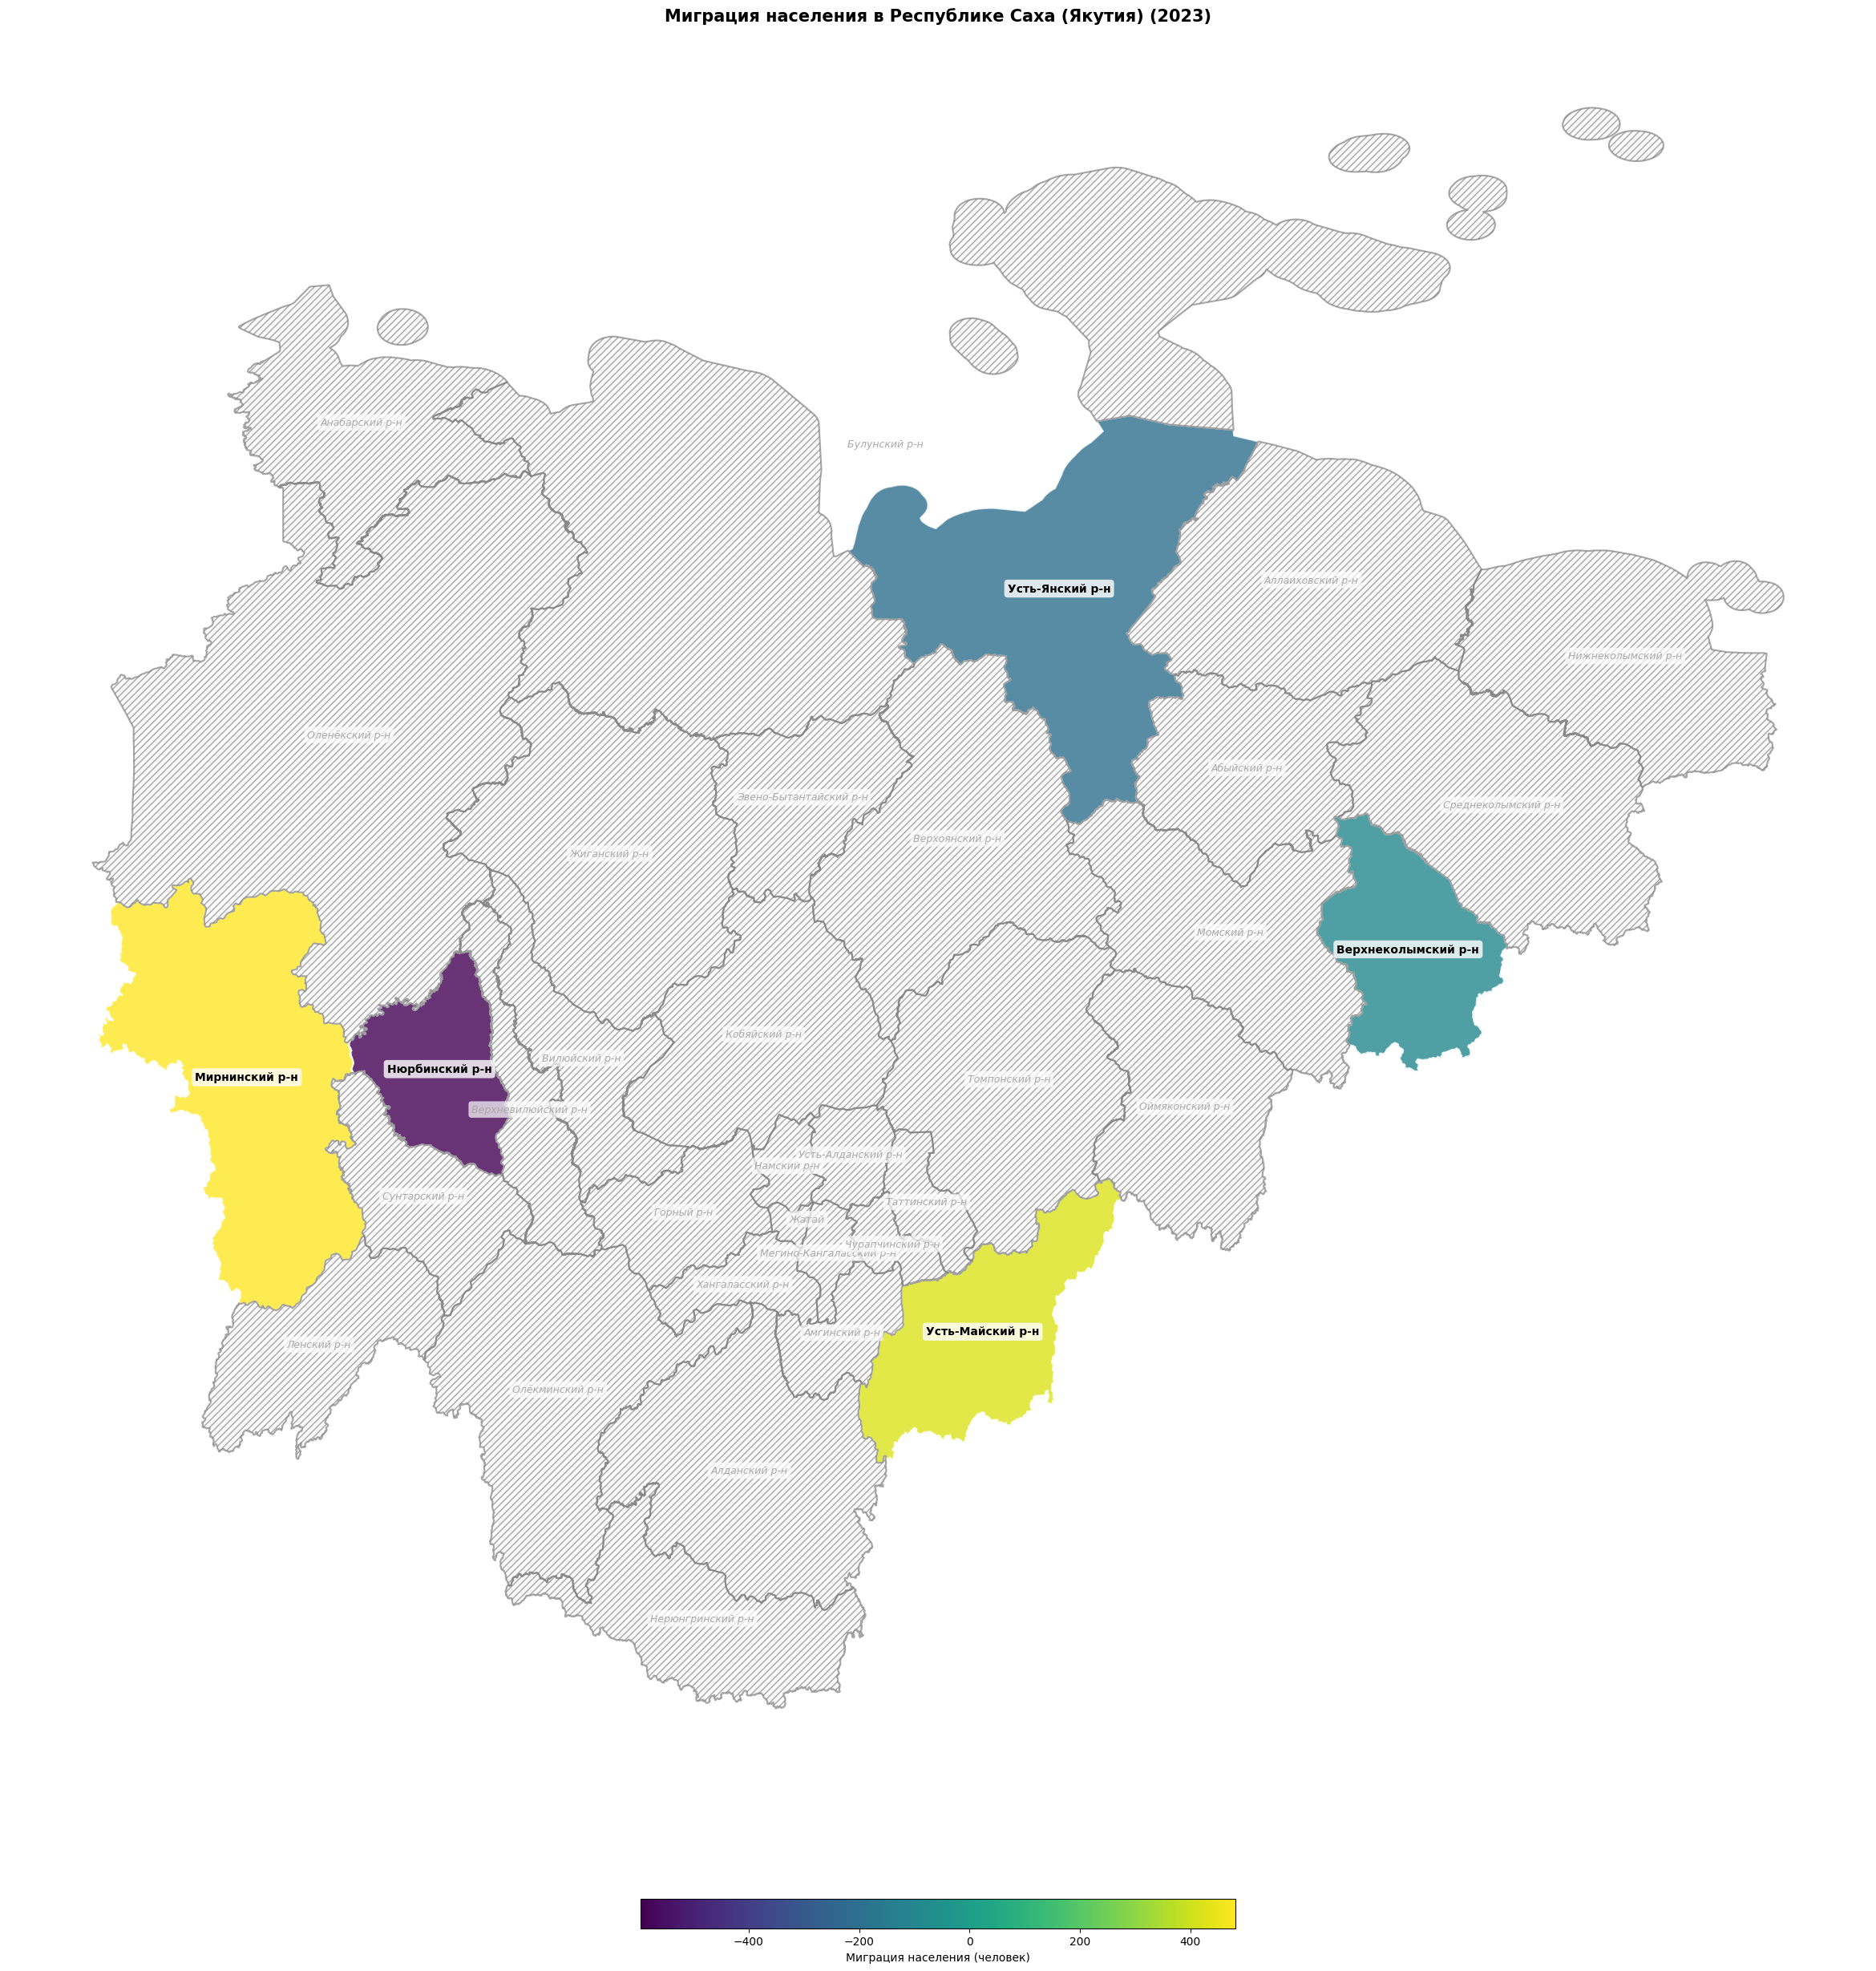

In [ ]:
fig_YA, ax_YA = plt.subplots(1, 1, figsize=(30, 28))

merged_YA.plot(
    column='value_of_migration_2023',
    cmap='viridis',
    legend=True,
    ax=ax_YA,
    edgecolor='white',
    linewidth=1.5,
    alpha=0.8,
    missing_kwds={
        'color': 'whitesmoke',
        'edgecolor': 'none',
        'alpha': 0.3
    },
    legend_kwds={
        'label': 'Миграция населения (человек)',
        'shrink': 0.25,
        'orientation': 'horizontal',
        'pad': 0.05
    }
)

# Штриховка для объектов без данных миграции
no_data_mask = merged_YA['value_of_migration_2023'].isna()
if no_data_mask.any():
    merged_YA[no_data_mask].plot(
        ax=ax_YA,
        color='none',  # Прозрачная заливка
        edgecolor='grey',
        linewidth=1.5,
        hatch='////',  # Штриховка
        alpha=0.7
    )

ax_YA.set_title('Миграция населения в Республике Саха (Якутия) (2023)',
                 fontsize=15, fontweight='bold', color='black')
ax_YA.set_axis_off()

# Добавляем подписи муниципалитетов
for idx, row in merged_YA.iterrows():
    centroid_YA = row['geometry'].centroid

    # Сокращаем названия
    district_name_YA = row['district']
    if 'район' in district_name_YA:
        short_name_YA = district_name_YA.replace(' район', ' р-н')
    else:
        short_name_YA = district_name_YA

    # Пропускаем подпись для определенных муниципалитетов (при необходимости)
    skip_districts_YA = ['город Якутск']
    if short_name_YA in skip_districts_YA:
        continue

    if pd.notna(row['value_of_migration_2023']):
        ax_YA.annotate(
            text=short_name_YA,
            xy=(centroid_YA.x, centroid_YA.y),
            ha='center',
            va='center',
            fontsize=10,
            fontweight='bold',
            color='black',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.8,
                edgecolor='none'
            )
        )
    else:
        ax_YA.annotate(
            text=short_name_YA,
            xy=(centroid_YA.x, centroid_YA.y),
            ha='center',
            va='center',
            fontsize=9,
            color='darkgray',
            style='italic',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.7,
                edgecolor='none'
            )
        )

plt.tight_layout()
plt.show()

## Республика Коми

In [ ]:
gdf_K = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Республика Коми_Komi region.geojson')

In [ ]:
# Получение уникальных названий муниципалитетов
unique_districts_K = gdf_K['district'].unique()
print('Уникальные муниципалитеты:')
for district in sorted(unique_districts_K):
    print(f"- {district}")

# Или просто список
print(f"\nВсего уникальных муниципалитетов: {len(unique_districts_K)}")

Уникальные муниципалитеты:
- Воркута
- Вуктыл
- Ижемский район
- Инта
- Княжпогостский район
- Койгородский район
- Корткеросский район
- Печора
- Прилузский район
- Сосногорск
- Сыктывдинский район
- Сыктывкар
- Сысольский район
- Троицко-Печорский район
- Удорский район
- Усинск
- Усть-Вымский район
- Усть-Куломский район
- Усть-Цилемский район
- Ухта

Всего уникальных муниципалитетов: 20


In [ ]:
# Словарь для приведения названий муниципальных районов к единому формату для Республики Коми
district_mapping_K = {
    'городской округ сыктывкар': 'Сыктывкар',
    'городской округ воркута': 'Воркута',
    'городской округ ухта': 'Ухта',
    'ижемский муниципальный район': 'Ижемский район',
    'княжпогостский муниципальный район': 'Княжпогостский район',
    'корткеросский муниципальный район': 'Корткеросский район',
    'муниципальный район печора': 'Печора',
    'прилузский муниципальный район': 'Прилузский район',
    'муниципальный район сосногорск': 'Сосногорск',
    'сыктывдинский муниципальный район': 'Сыктывдинский район',
    'сысольский муниципальный район': 'Сысольский район',
    'троицко-печорский муниципальный район': 'Троицко-Печорский район',
    'удорский муниципальный район': 'Удорский район',
    'усть-вымский муниципальный район': 'Усть-Вымский район',
    'усть-куломский муниципальный район': 'Усть-Куломский район',
    'усть-цилемский муниципальный район': 'Усть-Цилемский район'
}

df['district_normalized'] = df['municipality_name'].str.lower().map(district_mapping_K)

# Удаляем строки, для которых не нашлось соответствия
migration_df_clean_K = df.dropna(subset=['district_normalized'])

In [ ]:
# Объединяем геоданные с данными миграции
merged_K = gdf_K.merge(
    migration_df_clean_K,
    left_on='district',
    right_on='district_normalized',
    how='left'
)

# Проверяем результат
print("Результат объединения: ")
print(f"Всего записей: {len(merged_K)}")
print(f"Записей с данными миграции: {merged_K['value_of_migration_2023'].notna().sum()}")

Результат объединения: 
Всего записей: 20
Записей с данными миграции: 16


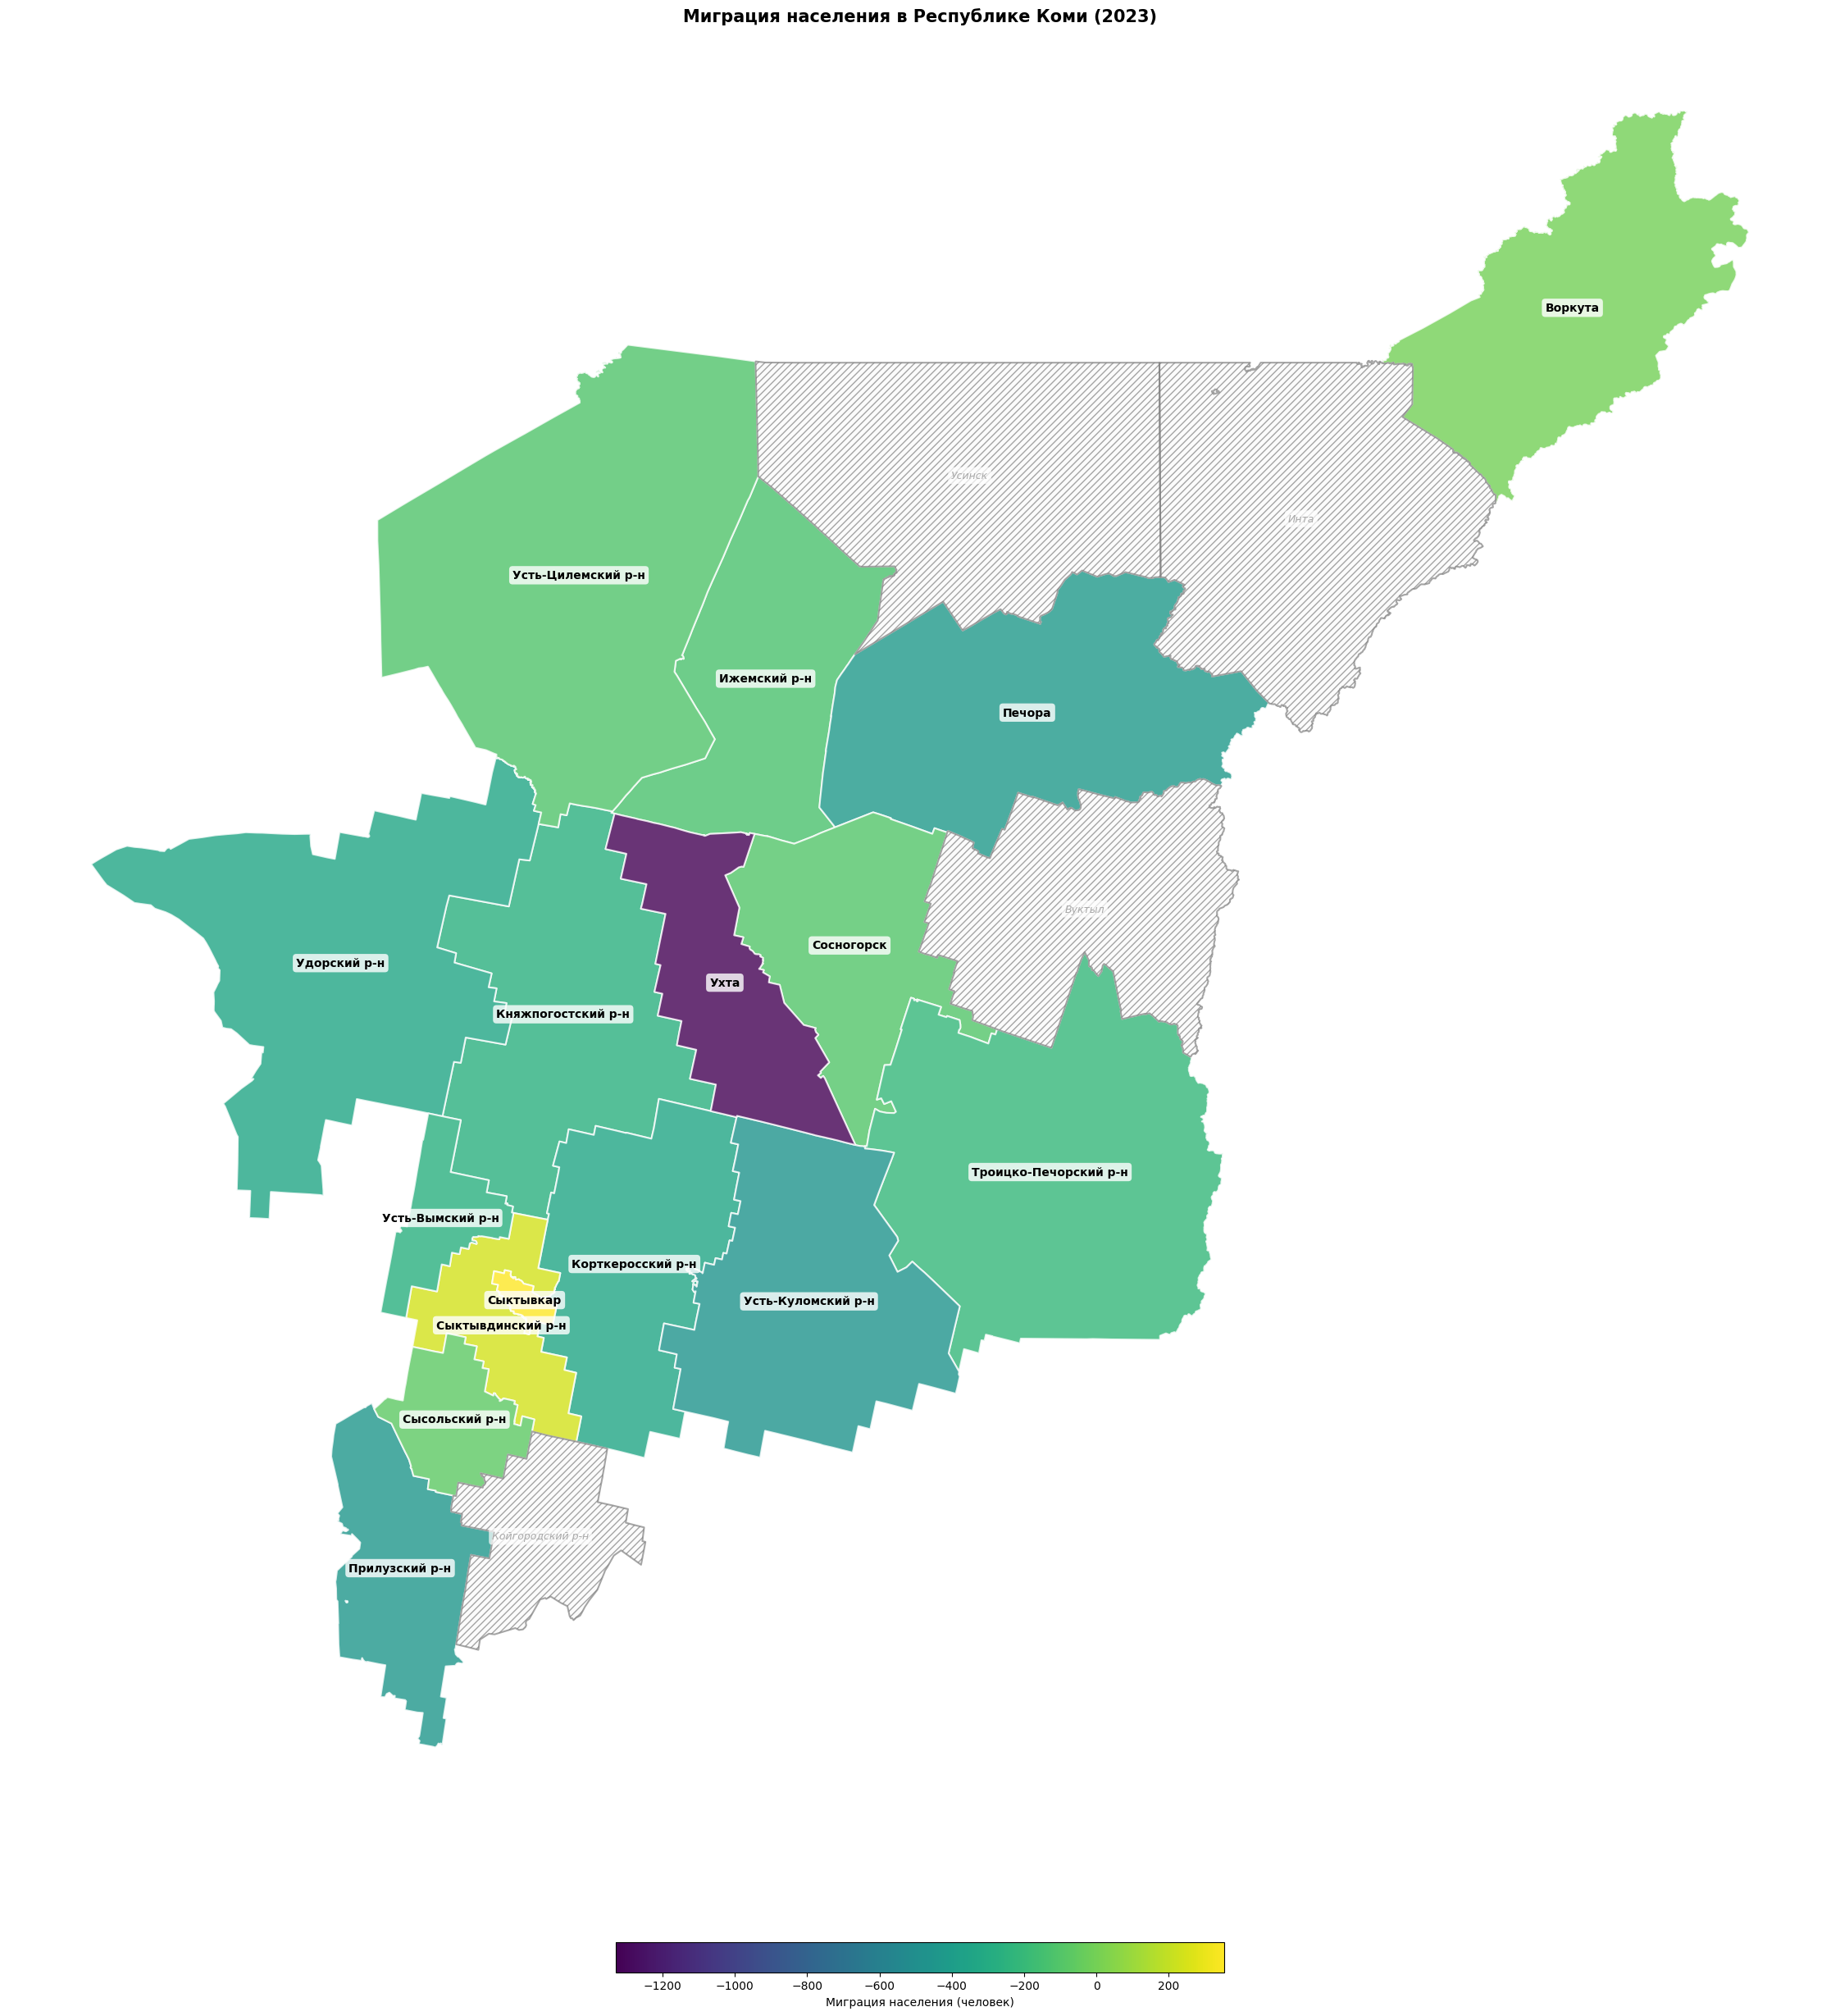

In [ ]:
fig_K, ax_K = plt.subplots(1, 1, figsize=(30, 28))

merged_K.plot(
    column='value_of_migration_2023',
    cmap='viridis',
    legend=True,
    ax=ax_K,
    edgecolor='white',
    linewidth=1.5,
    alpha=0.8,
    missing_kwds={
        'color': 'whitesmoke',
        'edgecolor': 'none',
        'alpha': 0.3
    },
    legend_kwds={
        'label': 'Миграция населения (человек)',
        'shrink': 0.25,
        'orientation': 'horizontal',
        'pad': 0.05
    }
)

# Штриховка для объектов без данных миграции
no_data_mask = merged_K['value_of_migration_2023'].isna()
if no_data_mask.any():
    merged_K[no_data_mask].plot(
        ax=ax_K,
        color='none',  # Прозрачная заливка
        edgecolor='grey',
        linewidth=1.5,
        hatch='////',  # Штриховка
        alpha=0.7
    )

ax_K.set_title('Миграция населения в Республике Коми (2023)',
                 fontsize=15, fontweight='bold', color='black')
ax_K.set_axis_off()

# Добавляем подписи муниципалитетов
for idx, row in merged_K.iterrows():
    centroid_K = row['geometry'].centroid

    # Сокращаем названия для K
    district_name_K = row['district']
    if 'район' in district_name_K:
        short_name_K = district_name_K.replace(' район', ' р-н')
    else:
        short_name_K = district_name_K

    # Пропускаем подпись для определенных муниципалитетов (при необходимости)
    skip_districts_K = []
    if short_name_K in skip_districts_K:
        continue

    if pd.notna(row['value_of_migration_2023']):
        ax_K.annotate(
            text=short_name_K,
            xy=(centroid_K.x, centroid_K.y),
            ha='center',
            va='center',
            fontsize=10,
            fontweight='bold',
            color='black',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.8,
                edgecolor='none'
            )
        )
    else:
        ax_K.annotate(
            text=short_name_K,
            xy=(centroid_K.x, centroid_K.y),
            ha='center',
            va='center',
            fontsize=9,
            color='darkgray',
            style='italic',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.7,
                edgecolor='none'
            )
        )

plt.tight_layout()
plt.show()

## Красноярский край

In [ ]:
gdf_KYA = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Красноярский край_Krasnoyarsk Region.geojson')

In [ ]:
# Получение уникальных названий муниципалитетов
unique_districts_KYA = gdf_KYA['district'].unique()
print('Уникальные муниципалитеты:')
for district in sorted(unique_districts_KYA):
    print(f"- {district}")

# Или просто список
print(f"\nВсего уникальных муниципалитетов: {len(unique_districts_KYA)}")

Уникальные муниципалитеты:
- Абанский район
- Ачинск
- Ачинский район
- Балахтинский район
- Березовский район
- Бирилюсский район
- Боготол
- Боготольский район
- Богучанский район
- Большемуртинский район
- Большеулуйский район
- Бородино
- Дзержинский район
- Дивногорск
- Емельяновский район
- Енисейск
- Енисейский район
- Ермаковский район
- ЗАТО Железногорск
- ЗАТО Зеленогорск
- ЗАТО Солнечный
- Идринский район
- Иланский район
- Ирбейский район
- Казачинский район
- Канск
- Канский район
- Каратузский район
- Кежемский район
- Козульский район
- Краснотуранский район
- Красноярск
- Курагинский район
- Лесосибирск
- Манский район
- Минусинск
- Минусинский район
- Мотыгинский район
- Назарово
- Назаровский район
- Нижнеингашский район
- Новоселовский район
- Норильск
- Партизанский район
- Пировский район
- Рыбинский район
- Саянский район
- Северо-Енисейский район
- Сосновоборск
- Сухобузимский район
- Таймырский район
- Тасеевский район
- Туруханский район
- Тюхтетский район
- Уж

In [ ]:
# Словарь для приведения названий муниципальных районов к единому формату
district_mapping_KYA = {
    'богучанский муниципальный район': 'Богучанский район',
    'енисейский муниципальный район': 'Енисейский район',
    'мотыгинский муниципальный район': 'Мотыгинский район',
    'северо-енисейский муниципальный район': 'Северо-Енисейский район',
    'таймырский долгано-ненецкий муниципальный район': 'Таймырский район',
    'туруханский муниципальный район': 'Туруханский район',
    'эвенкийский муниципальный район': 'Эвенкийский район'
}

df['district_normalized'] = df['municipality_name'].str.lower().map(district_mapping_KYA)

# Удаляем строки, для которых не нашлось соответствия
migration_df_clean_KYA = df.dropna(subset=['district_normalized'])

In [ ]:
# Объединяем геоданные с данными миграции
merged_KYA = gdf_KYA.merge(
    migration_df_clean_KYA,
    left_on='district',
    right_on='district_normalized',
    how='left'
)

# Проверяем результат
print("Результат объединения: ")
print(f"Всего записей: {len(merged_KYA)}")
print(f"Записей с данными миграции: {merged_KYA['value_of_migration_2023'].notna().sum()}")

Результат объединения: 
Всего записей: 61
Записей с данными миграции: 7


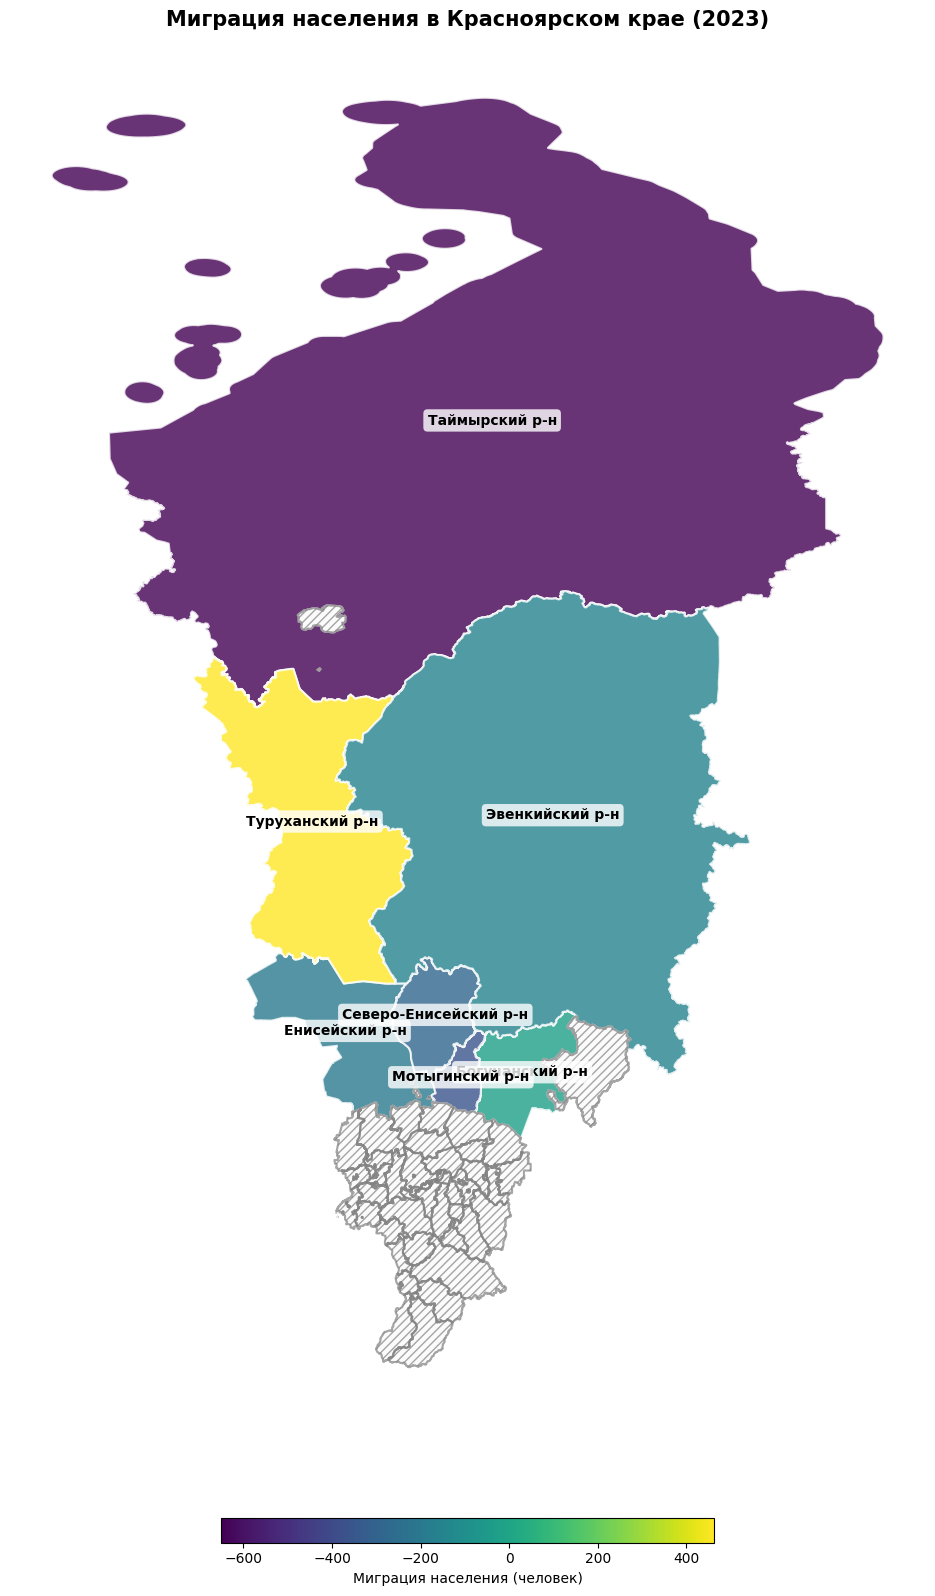

In [ ]:
fig_KYA, ax_KYA = plt.subplots(1, 1, figsize=(20, 18))

merged_KYA.plot(
    column='value_of_migration_2023',
    cmap='viridis',
    legend=True,
    ax=ax_KYA,
    edgecolor='white',
    linewidth=1.5,
    alpha=0.8,
    missing_kwds={
        'color': 'whitesmoke',
        'edgecolor': 'none',
        'alpha': 0.3
    },
    legend_kwds={
        'label': 'Миграция населения (человек)',
        'shrink': 0.25,
        'orientation': 'horizontal',
        'pad': 0.05
    }
)

# Штриховка для объектов без данных миграции
no_data_mask = merged_KYA['value_of_migration_2023'].isna()
if no_data_mask.any():
    merged_KYA[no_data_mask].plot(
        ax=ax_KYA,
        color='none',  # Прозрачная заливка
        edgecolor='grey',
        linewidth=1.5,
        hatch='////',  # Штриховка
        alpha=0.7
    )

ax_KYA.set_title('Миграция населения в Красноярском крае (2023)',
                 fontsize=15, fontweight='bold', color='black')
ax_KYA.set_axis_off()

# Добавляем подписи муниципалитетов
for idx, row in merged_KYA.iterrows():
    # Пропускаем если нет данных миграции
    if pd.isna(row['value_of_migration_2023']):
        continue

    centroid_KYA = row['geometry'].centroid

    # Сокращаем названия
    district_name_KYA = row['district']
    if 'район' in district_name_KYA:
        short_name_KYA = district_name_KYA.replace(' район', ' р-н')
    else:
        short_name_KYA = district_name_KYA

    # Пропускаем подпись для определенных муниципалитетов (при необходимости)
    skip_districts_KYA = []  # можно добавить муниципалитеты для пропуска
    if short_name_KYA in skip_districts_KYA:
        continue

    ax_KYA.annotate(
        text=short_name_KYA,
        xy=(centroid_KYA.x, centroid_KYA.y),
        ha='center',
        va='center',
        fontsize=10,
        fontweight='bold',
        color='black',
        bbox=dict(
            boxstyle="round,pad=0.3",
            facecolor='white',
            alpha=0.8,
            edgecolor='none'
        )
    )

plt.tight_layout()
plt.show()

## Мурманская область

In [ ]:
gdf_MR = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Мурманская область_Murmansk region.geojson')

In [ ]:
# Получение уникальных названий муниципалитетов
unique_districts_MR = gdf_MR['district'].unique()
print('Уникальные муниципалитеты:')
for district in sorted(unique_districts_MR):
    print(f"- {district}")

# Или просто список
print(f"\nВсего уникальных муниципалитетов: {len(unique_districts_MR)}")

Уникальные муниципалитеты:
- Апатиты
- ЗАТО Александровск
- ЗАТО Видяево
- ЗАТО Заозерск
- ЗАТО Островной
- ЗАТО Североморск
- Зори
- Кандалакшский район
- Кировск
- Ковдорский район
- Кольский район
- Ловозерский район
- Мончегорск
- Мурманск
- Оленегорск
- Печенгский район
- Терский район

Всего уникальных муниципалитетов: 17


In [ ]:
# Словарь для приведения названий муниципальных районов к единому формату для Мурманской области
district_mapping_MR = {
    'городской округ поселок видяево (зато)': 'ЗАТО Видяево',
    'городской округ город североморск (зато)': 'ЗАТО Североморск',
    'кандалакшский муниципальный район': 'Кандалакшский район',
    'кольский муниципальный район': 'Кольский район',
    'ловозерский муниципальный район': 'Ловозерский район',
    'печенгский муниципальный округ': 'Печенгский район',
    'терский муниципальный район': 'Терский район'
}

df['district_normalized'] = df['municipality_name'].str.lower().map(district_mapping_MR)

# Удаляем строки, для которых не нашлось соответствия
migration_df_clean_MR = df.dropna(subset=['district_normalized'])

In [ ]:
# Объединяем геоданные с данными миграции
merged_MR = gdf_MR.merge(
    migration_df_clean_MR,
    left_on='district',
    right_on='district_normalized',
    how='left'
)

# Проверяем результат
print("Результат объединения: ")
print(f"Всего записей: {len(merged_MR)}")
print(f"Записей с данными миграции: {merged_MR['value_of_migration_2023'].notna().sum()}")

Результат объединения: 
Всего записей: 17
Записей с данными миграции: 7


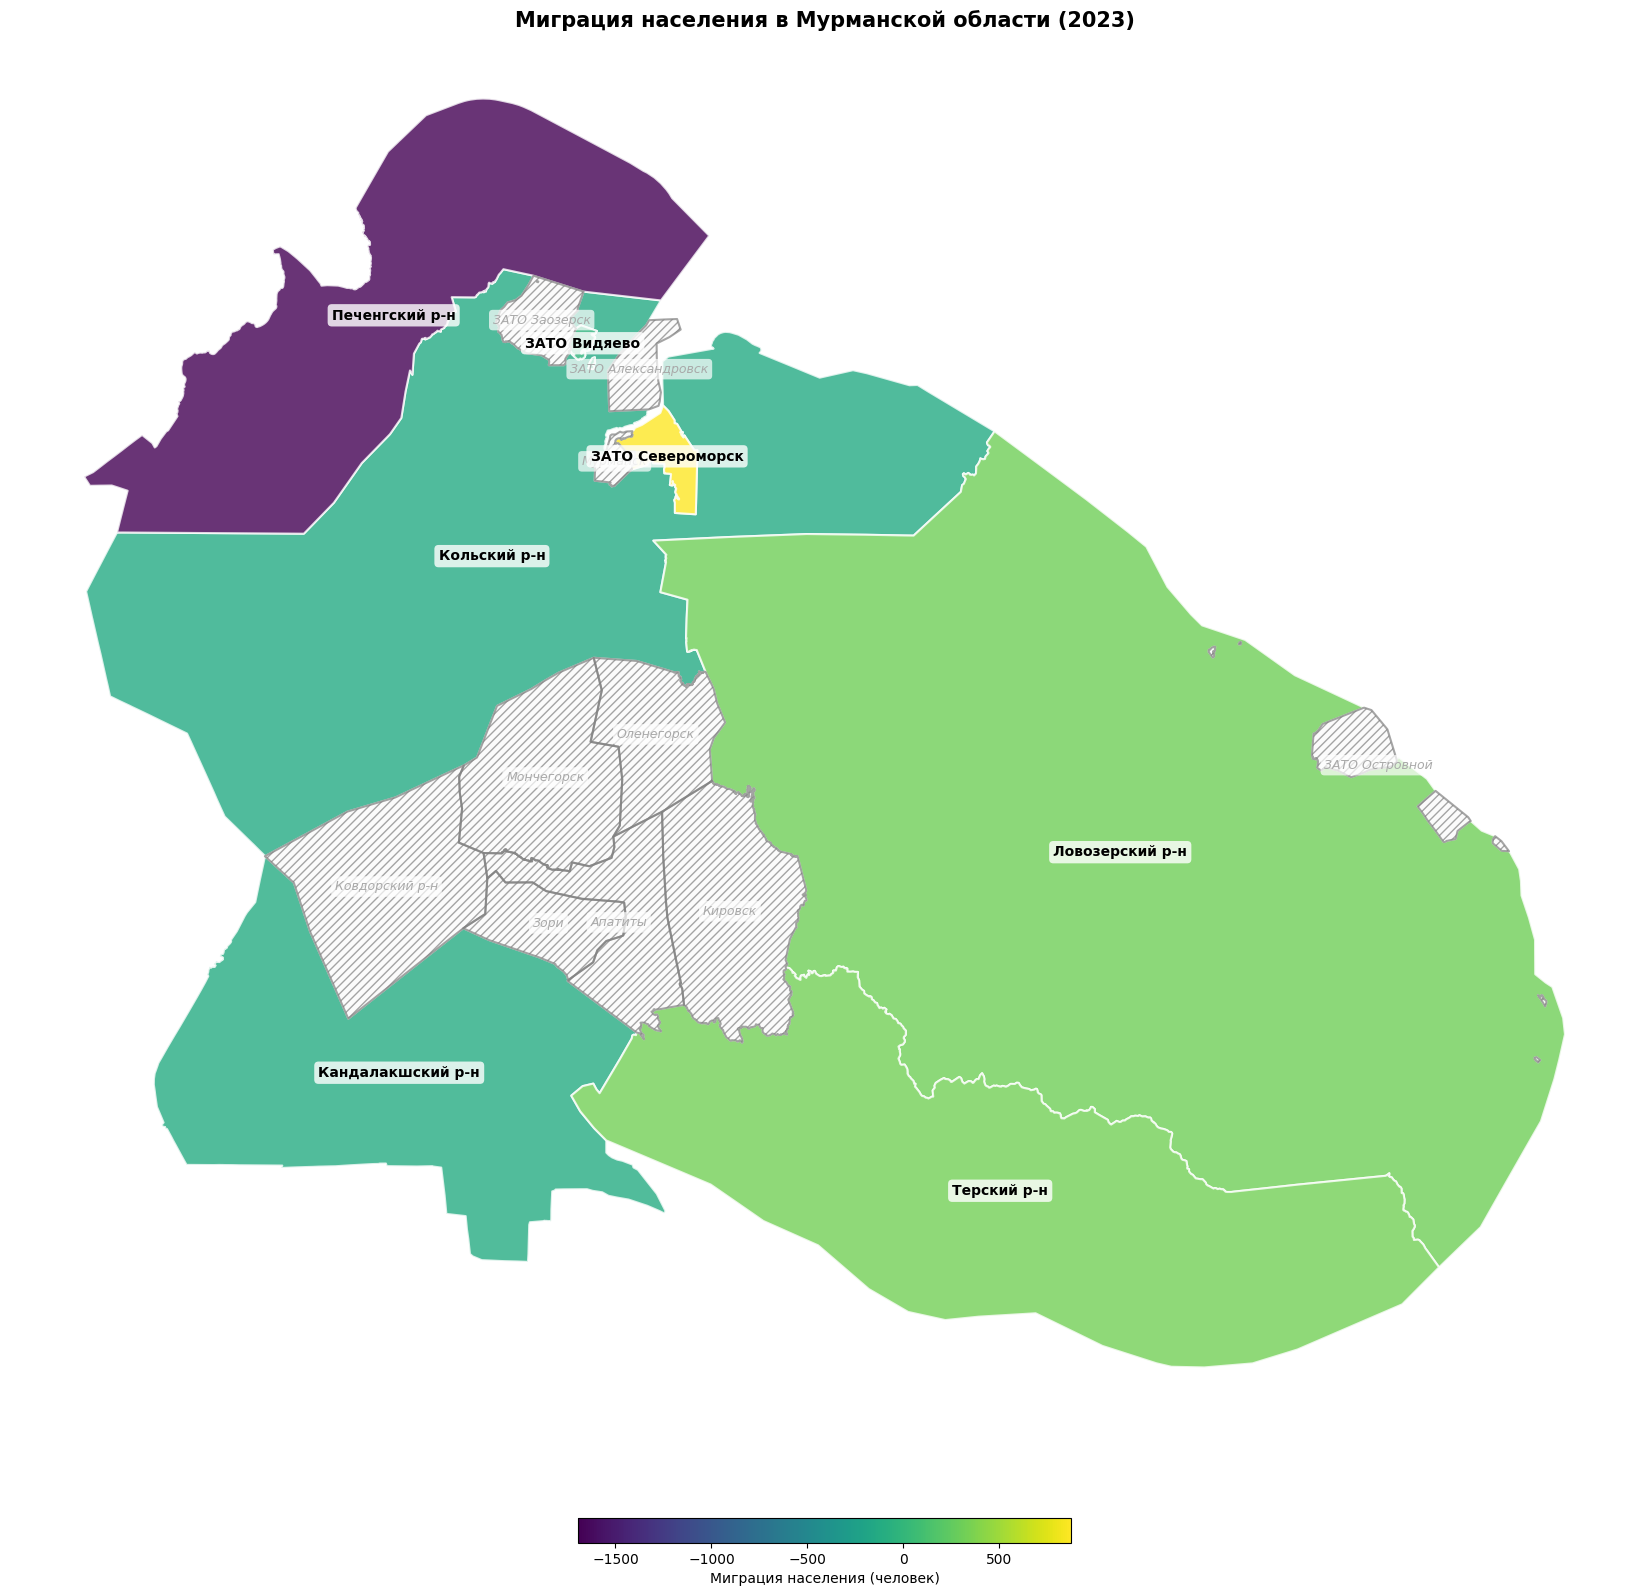

In [ ]:
fig_MR, ax_MR = plt.subplots(1, 1, figsize=(20, 18))

merged_MR.plot(
    column='value_of_migration_2023',
    cmap='viridis',
    legend=True,
    ax=ax_MR,
    edgecolor='white',
    linewidth=1.5,
    alpha=0.8,
    missing_kwds={
        'color': 'whitesmoke',
        'edgecolor': 'none',
        'alpha': 0.3
    },
    legend_kwds={
        'label': 'Миграция населения (человек)',
        'shrink': 0.25,
        'orientation': 'horizontal',
        'pad': 0.05
    }
)

# Штриховка для объектов без данных миграции
no_data_mask = merged_MR['value_of_migration_2023'].isna()
if no_data_mask.any():
    merged_MR[no_data_mask].plot(
        ax=ax_MR,
        color='none',  # Прозрачная заливка
        edgecolor='grey',
        linewidth=1.5,
        hatch='////',  # Штриховка
        alpha=0.7
    )

ax_MR.set_title('Миграция населения в Мурманской области (2023)',
                 fontsize=15, fontweight='bold', color='black')
ax_MR.set_axis_off()

# Добавляем подписи муниципалитетов для MR (всех, но с разным стилем)
for idx, row in merged_MR.iterrows():
    centroid_MR = row['geometry'].centroid

    # Сокращаем названия для MR
    district_name_MR = row['district']
    if 'район' in district_name_MR:
        short_name_MR = district_name_MR.replace(' район', ' р-н')
    else:
        short_name_MR = district_name_MR

    # Пропускаем подпись для определенных муниципалитетов (при необходимости)
    skip_districts_MR = []  # можно добавить муниципалитеты для пропуска
    if short_name_MR in skip_districts_MR:
        continue

    # Разный стиль для регионов с данными и без данных
    if pd.notna(row['value_of_migration_2023']):
        # Регионы с данными - обычный стиль
        ax_MR.annotate(
            text=short_name_MR,
            xy=(centroid_MR.x, centroid_MR.y),
            ha='center',
            va='center',
            fontsize=10,
            fontweight='bold',
            color='black',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.8,
                edgecolor='none'
            )
        )
    else:
        # Регионы без данных - серый курсив
        ax_MR.annotate(
            text=short_name_MR,
            xy=(centroid_MR.x, centroid_MR.y),
            ha='center',
            va='center',
            fontsize=9,
            color='darkgray',
            style='italic',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.7,
                edgecolor='none'
            )
        )

plt.tight_layout()
plt.show()

## Мурманская область и Ямало-Ненецкий АО

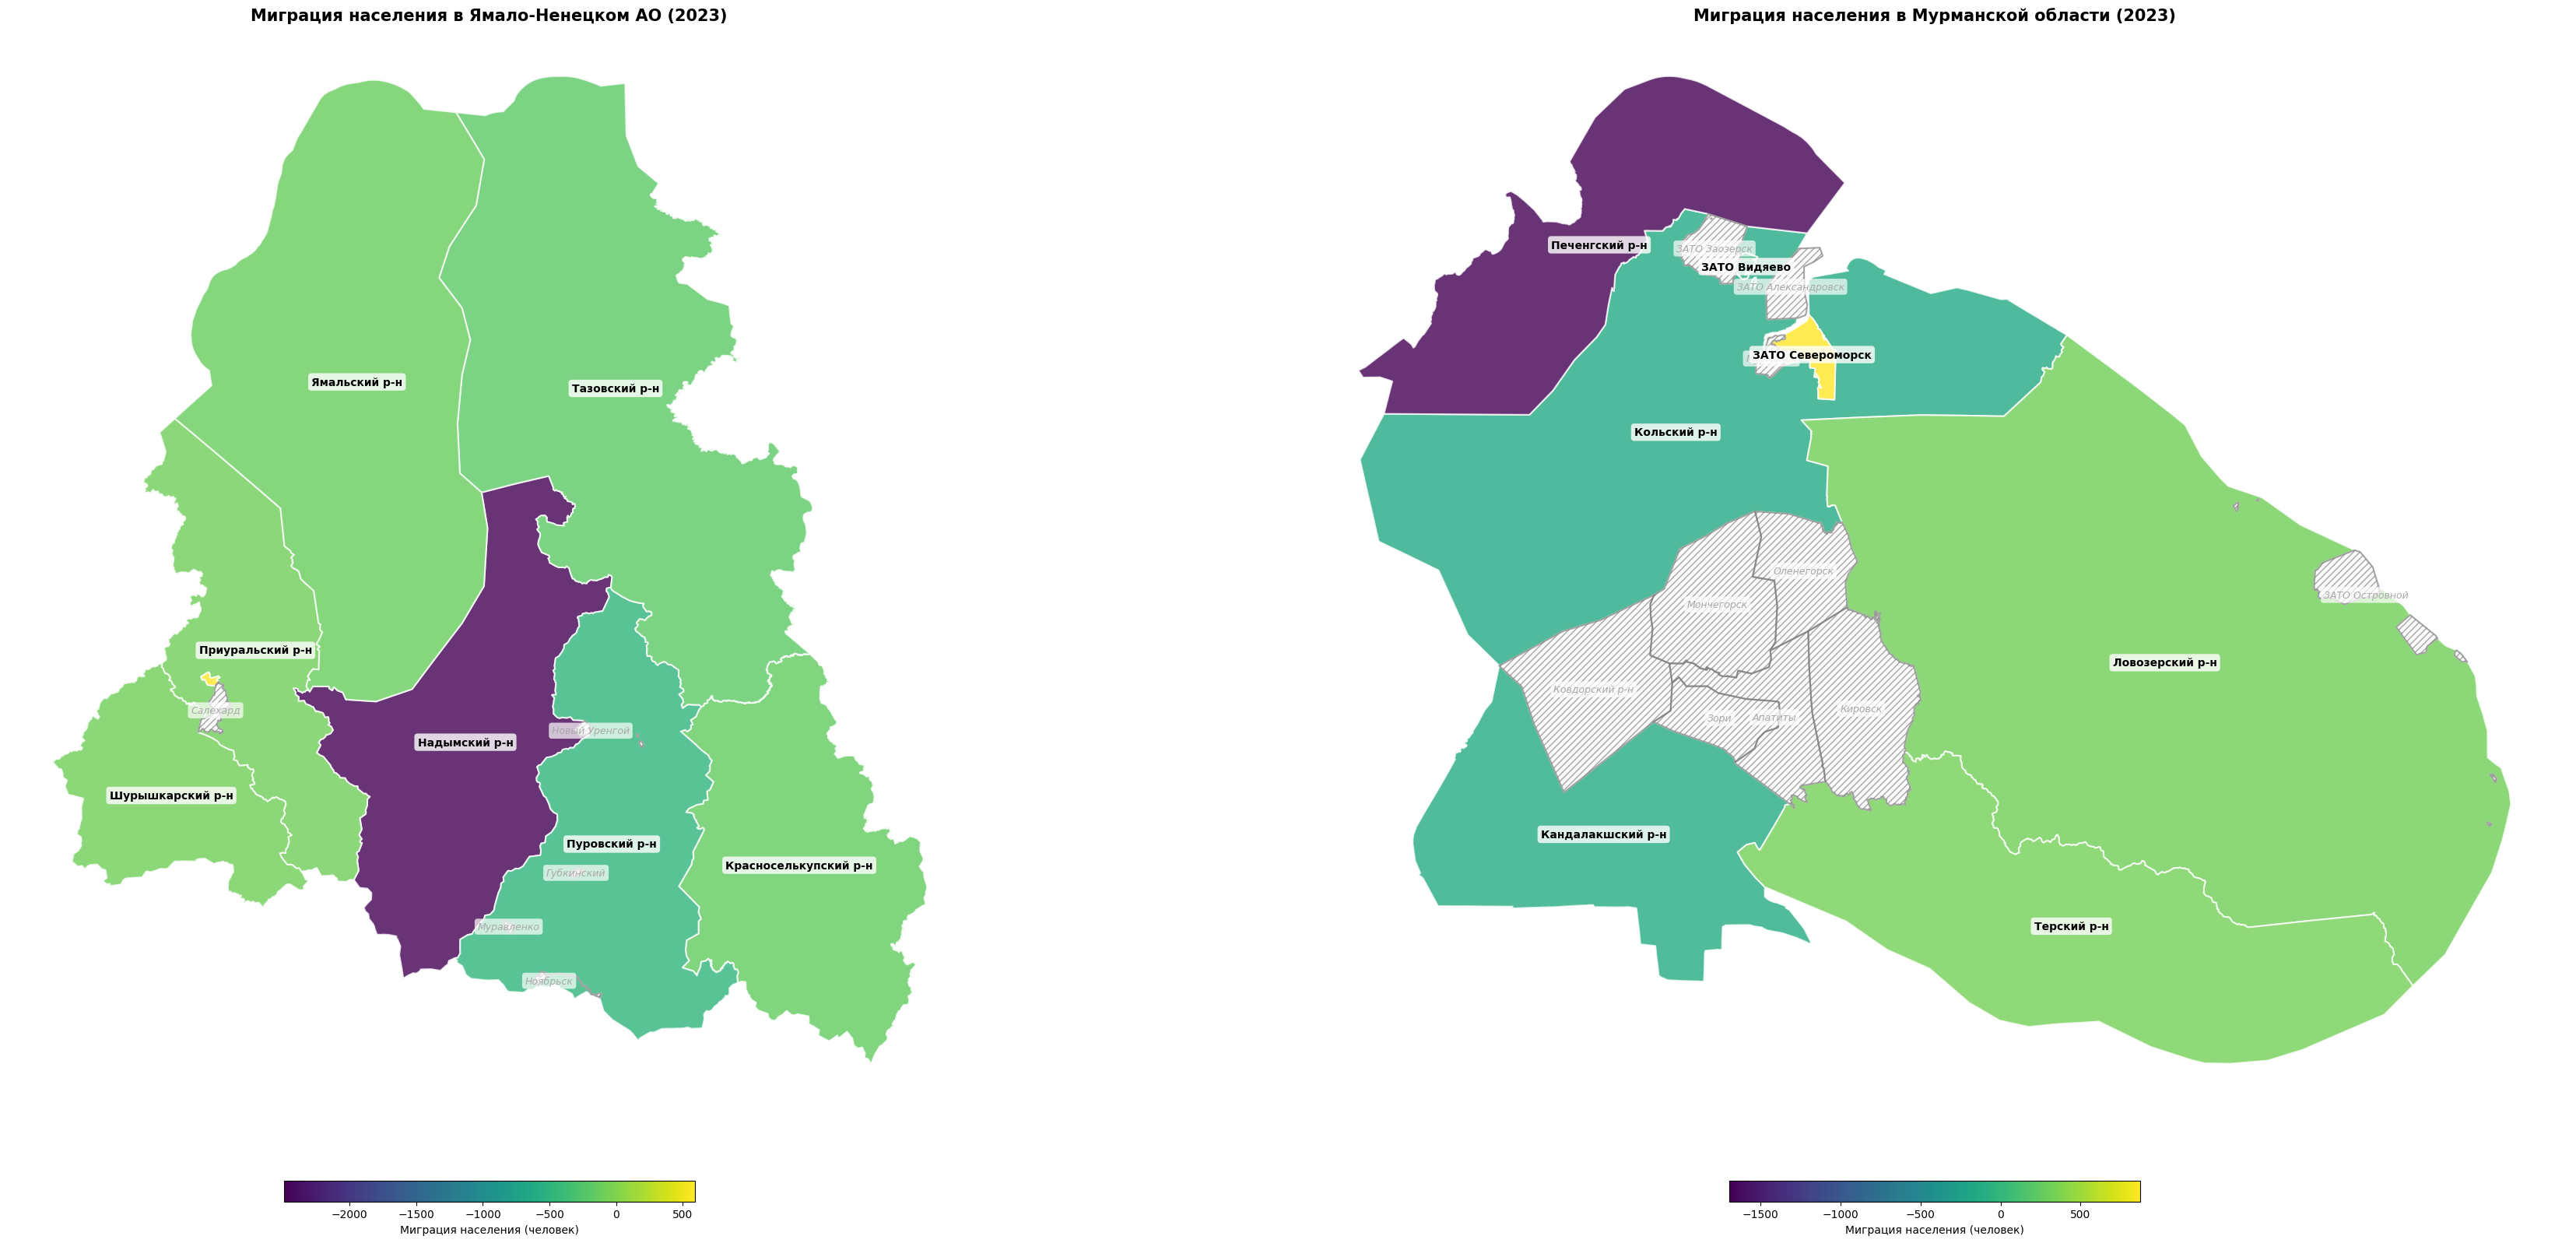

In [ ]:
# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 18))

# Первый график - Ямало-Ненецкий АО
merged.plot(
    column='value_of_migration_2023',
    cmap='viridis',
    legend=True,
    ax=ax1,
    edgecolor='white',
    linewidth=1.5,
    alpha=0.8,
    missing_kwds={
        'color': 'whitesmoke',
        'edgecolor': 'none',
        'alpha': 0.3
    },
    legend_kwds={
        'label': 'Миграция населения (человек)',
        'shrink': 0.25,
        'orientation': 'horizontal',
        'pad': 0.05
    }
)

# Штриховка для объектов без данных миграции (Ямало-Ненецкий АО)
no_data_mask = merged['value_of_migration_2023'].isna()
if no_data_mask.any():
    merged[no_data_mask].plot(
        ax=ax1,
        color='none',
        edgecolor='grey',
        linewidth=1.5,
        hatch='////',
        alpha=0.7
    )

ax1.set_title('Миграция населения в Ямало-Ненецком АО (2023)',
             fontsize=15, fontweight='bold', color='black')
ax1.set_axis_off()

# Добавляем подписи муниципалитетов для Ямало-Ненецкого АО
for idx, row in merged.iterrows():
    centroid = row['geometry'].centroid

    # Сокращаем названия
    district_name = row['district']
    if 'муниципальный район' in district_name:
        short_name = district_name.replace(' муниципальный район', ' р-н')
    elif 'район' in district_name:
        short_name = district_name.replace(' район', ' р-н')
    else:
        short_name = district_name

    # Пропускаем подпись для Лабытнанги
    if short_name == 'Лабытнанги':
        continue

    # Настройки подписей в зависимости от наличия данных
    if pd.notna(row['value_of_migration_2023']):
        ax1.annotate(
            text=short_name,
            xy=(centroid.x, centroid.y),
            ha='center',
            va='center',
            fontsize=10,
            fontweight='bold',
            color='black',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.8,
                edgecolor='none'
            )
        )
    else:
        ax1.annotate(
            text=short_name,
            xy=(centroid.x, centroid.y),
            ha='center',
            va='center',
            fontsize=9,
            color='darkgray',
            style='italic',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.7,
                edgecolor='none'
            )
        )

# Второй график - Мурманская область
merged_MR.plot(
    column='value_of_migration_2023',
    cmap='viridis',
    legend=True,
    ax=ax2,
    edgecolor='white',
    linewidth=1.5,
    alpha=0.8,
    missing_kwds={
        'color': 'whitesmoke',
        'edgecolor': 'none',
        'alpha': 0.3
    },
    legend_kwds={
        'label': 'Миграция населения (человек)',
        'shrink': 0.25,
        'orientation': 'horizontal',
        'pad': 0.05
    }
)

# Штриховка для объектов без данных миграции (Мурманская область)
no_data_mask_MR = merged_MR['value_of_migration_2023'].isna()
if no_data_mask_MR.any():
    merged_MR[no_data_mask_MR].plot(
        ax=ax2,
        color='none',
        edgecolor='grey',
        linewidth=1.5,
        hatch='////',
        alpha=0.7
    )

ax2.set_title('Миграция населения в Мурманской области (2023)',
             fontsize=15, fontweight='bold', color='black')
ax2.set_axis_off()

# Добавляем подписи муниципалитетов для Мурманской области
for idx, row in merged_MR.iterrows():
    centroid_MR = row['geometry'].centroid

    # Сокращаем названия для MR
    district_name_MR = row['district']
    if 'район' in district_name_MR:
        short_name_MR = district_name_MR.replace(' район', ' р-н')
    else:
        short_name_MR = district_name_MR

    # Пропускаем подпись для определенных муниципалитетов (при необходимости)
    skip_districts_MR = []  # можно добавить муниципалитеты для пропуска
    if short_name_MR in skip_districts_MR:
        continue

    # Разный стиль для регионов с данными и без данных
    if pd.notna(row['value_of_migration_2023']):
        ax2.annotate(
            text=short_name_MR,
            xy=(centroid_MR.x, centroid_MR.y),
            ha='center',
            va='center',
            fontsize=10,
            fontweight='bold',
            color='black',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.8,
                edgecolor='none'
            )
        )
    else:
        ax2.annotate(
            text=short_name_MR,
            xy=(centroid_MR.x, centroid_MR.y),
            ha='center',
            va='center',
            fontsize=9,
            color='darkgray',
            style='italic',
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='white',
                alpha=0.7,
                edgecolor='none'
            )
        )

# Общая настройка компоновки
plt.tight_layout()
plt.show()

# Обзор корреляций

In [ ]:
poad_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Data_SberIndex_POAD.xlsx')

In [ ]:
poad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 94 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   region                                   128 non-null    object 
 1   municipality_up_name                     128 non-null    object 
 2   municipality_down_name                   128 non-null    object 
 3   settlement_name                          128 non-null    object 
 4   settlement_name_sep                      128 non-null    object 
 5   type                                     128 non-null    object 
 6   arctic                                   128 non-null    bool   
 7   remote                                   128 non-null    bool   
 8   special                                  128 non-null    object 
 9   suburb                                   128 non-null    bool   
 10  pop_men                                  124 non-n

In [ ]:
# Шаг 1: Анализ дубликатов в базе данных
print("Анализ дубликатов муниципалитетов:")
print(poad_df['municipality_up_name'].value_counts().head(10))

# Смотрим все записи Надымского района
nadym_duplicates = poad_df[poad_df['municipality_up_name'].str.contains('Надымский', na=False)]
print(f"\nНайдено записей Надымского района: {len(nadym_duplicates)}")
print("Уникальные названия:")
print(nadym_duplicates['municipality_up_name'].unique())
print("\nТипы населенных пунктов:")
print(nadym_duplicates['type'].value_counts())

Анализ дубликатов муниципалитетов:
municipality_up_name
Советский муниципальный район        6
Сургутский муниципальный район       5
Октябрьский муниципальный район      5
Кондинский муниципальный район       5
Кольский муниципальный район         4
Мирнинский муниципальный район       4
Эвенкийский муниципальный район      3
Муниципальный район Удорский         3
Городской округ Ухта                 3
Нефтеюганский муниципальный район    3
Name: count, dtype: int64

Найдено записей Надымского района: 2
Уникальные названия:
['Муниципальный округ Надымский район']

Типы населенных пунктов:
type
пгт    2
Name: count, dtype: int64


In [ ]:
# Шаг 2: Агрегация данных по Надымскому району
# Создаем копию DataFrame для агрегации
poad_agg = poad_df.copy()

# Идентифицируем все записи Надымского района
nadym_mask = poad_agg['municipality_up_name'].str.contains('Надымский', na=False)

print("До агрегации:")
print(f"Всего записей: {len(poad_agg)}")
print(f"Записей Надымского района: {nadym_mask.sum()}")

# Создаем агрегированную запись для Надымского района
numeric_cols = poad_agg.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = poad_agg.select_dtypes(exclude=[np.number]).columns.tolist()

# Для числовых колонок берем среднее, для нечисловых - первую запись
nadym_aggregated = pd.DataFrame()

for col in poad_agg.columns:
    if col in numeric_cols:
        # Для числовых колонок - среднее значение
        nadym_aggregated[col] = [poad_agg[nadym_mask][col].mean()]
    else:
        # Для нечисловых колонок - первое значение, но модифицируем название
        if col == 'municipality_up_name':
            nadym_aggregated[col] = ['Надымский район (агрегированный)']
        elif col == 'settlement_name':
            nadym_aggregated[col] = ['Надымский район']
        else:
            nadym_aggregated[col] = [poad_agg[nadym_mask][col].iloc[0] if len(poad_agg[nadym_mask][col]) > 0 else None]

# Удаляем старые записи Надымского района и добавляем агрегированную
poad_agg = poad_agg[~nadym_mask]
poad_agg = pd.concat([poad_agg, nadym_aggregated], ignore_index=True)

print("\nПосле агрегации:")
print(f"Всего записей: {len(poad_agg)}")
print(f"Записей Надымского района: {len(poad_agg[poad_agg['municipality_up_name'].str.contains('Надымский', na=False)])}")

До агрегации:
Всего записей: 128
Записей Надымского района: 2

После агрегации:
Всего записей: 127
Записей Надымского района: 1


In [ ]:
# Шаг 3: Проверка агрегированных данных
nadym_agg_check = poad_agg[poad_agg['municipality_up_name'].str.contains('Надымский', na=False)]
labytnangi_check = poad_agg[poad_agg['municipality_up_name'].str.contains('Лабытнанги', na=False)]

print("Агрегированные данные Надымского района:")
print(nadym_agg_check[['municipality_up_name', 'pop_total', 'wage_average', 'unemployed']])

print("\nДанные Лабытнанги:")
print(labytnangi_check[['municipality_up_name', 'pop_total', 'wage_average', 'unemployed']])

Агрегированные данные Надымского района:
                 municipality_up_name  pop_total  wage_average  unemployed
126  Надымский район (агрегированный)     6079.0      6.907906    2.724498

Данные Лабытнанги:
               municipality_up_name  pop_total  wage_average  unemployed
3  Городской округ город Лабытнанги     5031.0      4.411144   21.963824


In [ ]:
# Шаг 4: Визуализация с агрегированными данными
# Обновляем данные для визуализации
target_municipalities = ['Надымский район (агрегированный)', 'Городской округ город Лабытнанги']
municipality_data_agg = poad_agg[poad_agg['municipality_up_name'].isin(target_municipalities)].copy()

print("Данные для визуализации после агрегации:")
print(municipality_data_agg[['municipality_up_name', 'pop_total', 'wage_average', 'unemployed']])

Данные для визуализации после агрегации:
                 municipality_up_name  pop_total  wage_average  unemployed
3    Городской округ город Лабытнанги     5031.0      4.411144   21.963824
126  Надымский район (агрегированный)     6079.0      6.907906    2.724498


In [ ]:
# Шаг 5: Визуализация

comparison_metrics = [
    'pop_total', 'wage_average', 'unemployed', 'revenue_per_capita',
    'profit_bt_per_capita', 'housing_depreciation', 'emergency_housing',
    'space_per_capita', 'primary_avaiability', 'sport_facilities'
]

existing_metrics = [metric for metric in comparison_metrics if metric in poad_agg.columns]

In [ ]:
# Шаг 6: Создаем корректную таблицу сравнения
comparison_results = []

for metric in existing_metrics:
    nadym_val = municipality_data_agg[municipality_data_agg['short_name'] == 'Надымский район'][metric].values[0]
    labytnangi_val = municipality_data_agg[municipality_data_agg['short_name'] == 'Лабытнанги'][metric].values[0]

    comparison_results.append({
        'Показатель': metric,
        'Надымский район': nadym_val,
        'Лабытнанги': labytnangi_val,
        'Разница': nadym_val - labytnangi_val,
        'Отношение': nadym_val / labytnangi_val if labytnangi_val != 0 else float('inf')
    })

comparison_df = pd.DataFrame(comparison_results)

In [ ]:
# Шаг 7: Корректная сводная таблица сравнения
print("СВОДНОЕ СРАВНЕНИЕ ПОКАЗАТЕЛЕЙ\n")

# Создаем корректный DataFrame сравнения на основе актуальных данных
comparison_data = []

# Используем те же метрики, что и в визуализации
metrics = ['wage_average', 'revenue_per_capita', 'space_per_capita',
           'primary_avaiability', 'sport_facilities', 'unemployed']

for metric in metrics:
    if metric in municipality_data_agg.columns:
        nadym_val = municipality_data_agg[municipality_data_agg['short_name'] == 'Надымский район'][metric].values[0]
        labytnangi_val = municipality_data_agg[municipality_data_agg['short_name'] == 'Лабытнанги'][metric].values[0]

        comparison_data.append({
            'Показатель': metric,
            'Надымский район': nadym_val,
            'Лабытнанги': labytnangi_val,
            'Разница': nadym_val - labytnangi_val,
            'Отношение': nadym_val / labytnangi_val if labytnangi_val != 0 else float('inf')
        })

# Создаем DataFrame
comparison_df_corrected = pd.DataFrame(comparison_data)

# Красивые названия показателей
metric_names = {
    'wage_average': 'Средняя заработная плата',
    'revenue_per_capita': 'Доходы бюджета на душу населения',
    'space_per_capita': 'Жилая площадь на душу населения',
    'primary_avaiability': 'Доступность первичной медицины',
    'sport_facilities': 'Спортивные объекты',
    'unemployed': 'Уровень безработицы'
}

# Единицы измерения
metric_units = {
    'wage_average': 'тыс. руб.',
    'revenue_per_capita': 'тыс. руб.',
    'space_per_capita': 'кв. м',
    'primary_avaiability': 'балл',
    'sport_facilities': 'ед./1000 чел.',
    'unemployed': '%'
}

# Выводим сравнение
for _, row in comparison_df_corrected.iterrows():
    metric = row['Показатель']
    indicator = metric_names.get(metric, metric)
    unit = metric_units.get(metric, '')

    nadym = row['Надымский район']
    labytnangi = row['Лабытнанги']
    difference = row['Разница']

    # Определяем "победителя" для каждого показателя
    if metric == 'unemployed':  # для безработицы меньше = лучше
        winner = 'Надымский район' if nadym < labytnangi else 'Лабытнанги'
        symbol = '↓' if nadym < labytnangi else '↑'
        advantage = labytnangi - nadym if winner == 'Надымский район' else nadym - labytnangi
    else:  # для остальных показателей больше = лучше
        winner = 'Надымский район' if nadym > labytnangi else 'Лабытнанги'
        symbol = '↑' if nadym > labytnangi else '↓'
        advantage = nadym - labytnangi if winner == 'Надымский район' else labytnangi - nadym

    print(f"\n{indicator} ({unit}):")
    print(f"  Надымский район: {nadym:>8.1f} {unit}")
    print(f"  Лабытнанги:      {labytnangi:>8.1f} {unit}")
    print(f"  Разница:         {difference:>8.1f} {unit} {symbol}")

# Подсчитываем итоги
winners = []
for _, row in comparison_df_corrected.iterrows():
    metric = row['Показатель']
    nadym = row['Надымский район']
    labytnangi = row['Лабытнанги']

    if metric == 'unemployed':
        winner = 'Надымский район' if nadym < labytnangi else 'Лабытнанги'
    else:
        winner = 'Надымский район' if nadym > labytnangi else 'Лабытнанги'
    winners.append(winner)

nadym_wins = winners.count('Надымский район')
labytnangi_wins = winners.count('Лабытнанги')

print("\nИТОГОВЫЕ РЕЗУЛЬТАТЫ:\n")

# Анализ ключевых показателей
key_insights = []

for metric in ['wage_average', 'revenue_per_capita', 'unemployed']:
    if metric in comparison_df_corrected['Показатель'].values:
        row = comparison_df_corrected[comparison_df_corrected['Показатель'] == metric].iloc[0]
        nadym = row['Надымский район']
        labytnangi = row['Лабытнанги']

        if metric == 'wage_average':
            insight = f"Заработная плата: в Надымском районе на {abs(row['Разница']):.1f} тыс. руб. {'выше' if row['Разница'] > 0 else 'ниже'}"
        elif metric == 'revenue_per_capita':
            insight = f"Доходы бюджета: в Лабытнанги в {labytnangi/nadym:.1f} раза выше" if labytnangi > nadym else f"• Доходы бюджета: в Надымском районе в {nadym/labytnangi:.1f} раза выше"
        elif metric == 'unemployed':
            insight = f"Безработица: в Надымском районе в {labytnangi/nadym:.1f} раза ниже" if nadym < labytnangi else f"• Безработица: в Лабытнанги в {nadym/labytnangi:.1f} раза ниже"

        key_insights.append(insight)

# Выводим ключевые выводы
for insight in key_insights:
    print(insight)

СВОДНОЕ СРАВНЕНИЕ ПОКАЗАТЕЛЕЙ


Средняя заработная плата (тыс. руб.):
  Надымский район:      6.9 тыс. руб.
  Лабытнанги:           4.4 тыс. руб.
  Разница:              2.5 тыс. руб. ↑

Доходы бюджета на душу населения (тыс. руб.):
  Надымский район:     50.4 тыс. руб.
  Лабытнанги:         317.3 тыс. руб.
  Разница:           -267.0 тыс. руб. ↓

Жилая площадь на душу населения (кв. м):
  Надымский район:     22.8 кв. м
  Лабытнанги:          18.3 кв. м
  Разница:              4.5 кв. м ↑

Доступность первичной медицины (балл):
  Надымский район:      0.8 балл
  Лабытнанги:           1.0 балл
  Разница:             -0.2 балл ↓

Спортивные объекты (ед./1000 чел.):
  Надымский район:      0.5 ед./1000 чел.
  Лабытнанги:           1.2 ед./1000 чел.
  Разница:             -0.7 ед./1000 чел. ↓

Уровень безработицы (%):
  Надымский район:      2.7 %
  Лабытнанги:          22.0 %
  Разница:            -19.2 % ↓

ИТОГОВЫЕ РЕЗУЛЬТАТЫ:

Заработная плата: в Надымском районе на 2.5 тыс. руб. выше

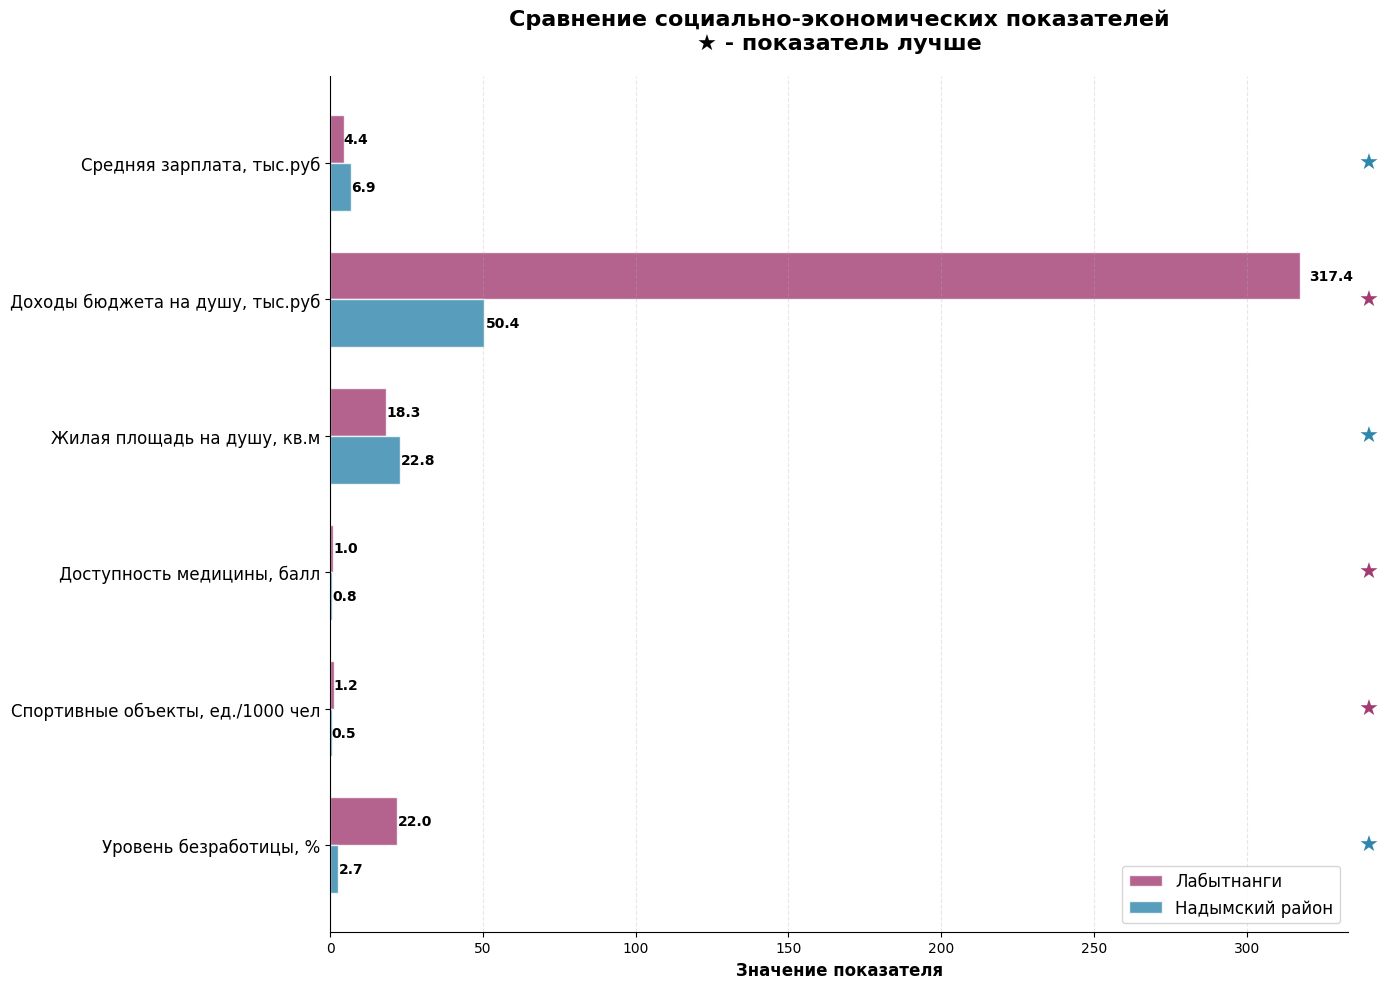

In [ ]:
# Шаг 8: Создание диаграммы расхождения (Diverging Bars) для наглядного сравнения
fig, ax = plt.subplots(figsize=(14, 10))

# Реальные значения показателей
metrics = ['wage_average', 'revenue_per_capita', 'space_per_capita',
           'primary_avaiability', 'sport_facilities', 'unemployed']

# Красивые названия показателей
metric_names = {
    'wage_average': 'Средняя зарплата, тыс.руб',
    'revenue_per_capita': 'Доходы бюджета на душу, тыс.руб',
    'space_per_capita': 'Жилая площадь на душу, кв.м',
    'primary_avaiability': 'Доступность медицины, балл',
    'sport_facilities': 'Спортивные объекты, ед./1000 чел',
    'unemployed': 'Уровень безработицы, %'
}

# Данные
labytnangi_vals = [4.41, 317.35, 18.34, 1.00, 1.19, 21.96]
nadym_vals = [6.91, 50.37, 22.84, 0.75, 0.49, 2.72]

# Определяем "победителя" для каждого показателя
winners = []
for i, (lab, nad) in enumerate(zip(labytnangi_vals, nadym_vals)):
    if metrics[i] == 'unemployed':  # для безработицы меньше = лучше
        winner = 'Надымский район' if nad < lab else 'Лабытнанги'
    else:  # для остальных показателей больше = лучше
        winner = 'Надымский район' if nad > lab else 'Лабытнанги'
    winners.append(winner)

# Создаем данные для диаграммы
y_pos = np.arange(len(metrics))
bar_height = 0.35

# Рисуем столбцы
bars1 = ax.barh(y_pos - bar_height/2, labytnangi_vals, bar_height,
                label='Лабытнанги', color='#A23B72', alpha=0.8, edgecolor='white', linewidth=1)
bars2 = ax.barh(y_pos + bar_height/2, nadym_vals, bar_height,
                label='Надымский район', color='#2E86AB', alpha=0.8, edgecolor='white', linewidth=1)

# Настройка осей
ax.set_yticks(y_pos)
ax.set_yticklabels([metric_names[m] for m in metrics], fontsize=12)
ax.invert_yaxis()  # чтобы показатели шли сверху вниз
ax.set_xlabel('Значение показателя', fontsize=12, fontweight='bold')

# Добавляем значения на столбцы
for bars, values in zip([bars1, bars2], [labytnangi_vals, nadym_vals]):
    for bar, value in zip(bars, values):
        ax.text(bar.get_width() + bar.get_width()*0.01, bar.get_y() + bar.get_height()/2,
                f'{value:.1f}', ha='left', va='center', fontweight='bold', fontsize=10)

# Добавляем индикаторы победителей
for i, winner in enumerate(winners):
    color = '#2E86AB' if winner == 'Надымский район' else '#A23B72'
    ax.text(1.02, i, '★', transform=ax.get_yaxis_transform(),
            fontsize=16, color=color, ha='center', va='center')

# Легенда и заголовок
ax.legend(loc='lower right', fontsize=12, frameon=True, fancybox=True)
ax.set_title('Сравнение социально-экономических показателей\n★ - показатель лучше',
             fontsize=16, fontweight='bold', pad=20)

# Сетка
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()